# [Draft] **Workbook for the study of coordinated reset in a simulation of subthalamic nucleus**

## Author Informtation
This work was performed by Matteo Coscia(1), Anthony Lee (1), Jesse Gilmer(1), Ali Khaledi-Nasab(2), and Mazen Al Borno(1).

1.   University of Colorado, School of Medicine - Computer Science and Bioengineering, and Computational Biology
2.   Amazon - Amazon Web Services Network Capacity Team.

The following is a work in progress. Contact J. Gilmer for queries at: jesse dot gilmer at cuanschutz dot edu.

To Do:
* Refine results text.
* Rework plotting functions.
* Setup a github and merge structure for the project.
* Do research into STN connectivity and projection anatomy.
* Make an RL agent for frequency and sites.
* Make matrix form of structured_conn().

# Abstract


Abnormal synchrony in the subthalamic nucleus is thought to be an intermediate etiology in Parkinson's disease symptomology. The application of high-frequency stimulation through implanted deep brain stimulators is thought to offset or interrupt aberrant outputs of the neural structures impacted by Parkinson's. However, high frequency stimulation has a number of off-target effects that can severely impact the quality of life for patients receiving this therapy, neccessitating alternatives. Research into therapies that treat the disease state of Parkinson's while reducing side effects have shown that random patterned stimulations, termed coordinated reset, can be effective in treating Parkinson's without relying on high frequency stimulation, thereby reducing negative effects of the therapy. This therapy is also thought to be an improvement over high-frequency stimualtion because the duration of its beneficial effects persists for longer than traditional stimuli. Interestingly, coordinated reset can also be applied through peripheral stimulation of the fingers, presumably by altering the statistics of inputs to the subthalamic nucleus through an ascending sensory pathway. While this therapy has been somewhat successful in small clinical trials, it remains unclear what the optimal stimulus patterning should be to best alleviate Parkinsonian symptoms. Here, we reestablish a computational model previously used to test stimulation patterns in peripheral coordinated reset and test a wide range of potential stimulation parameters to assay their effect on changes to connectivity weighting and synchrony, and find that low frequency stimuli across a moderate number of tactile sites best reduces abnormal synchrony in the system. Building upon this, we applied a reinforcement learning approach to parameter selection and found [something]. Additionally, we explore the effect of stimulation site selection by examining the effect of stimualting targets whose neural representation is relatively proximal vs those that are represented distally within the subthalamic nucleus and found [something]. The outcomes from this modelling approach can help clinicians to select the best course for treating Parkinson's disease, and other diseases of abnormal neural synchrony, using non-invasive peripheral therapies.

# Methods

## Model Dependencies
This model uses matplotlib, numpy, scipy, and the standard math package.


In [ ]:
import matplotlib.pyplot as plt    # MatPlotLib is a plotting package. 
import numpy as np                 # NumPy is a numerical types package.
from scipy import stats            # ScPy is a scientific computing package. We just want the stats, because Ca2+ imaging is always calculated in z-score.
from scipy.stats import circmean
import math
from posixpath import join

# Setup in-notebook plotting:
%matplotlib inline

##Model Description:
This LIF model is based on Kromer et al., 2020. [Go to Citations](#scrollTo=nbz2NLycMZr5)

This model seeks to establish a model of a neural circuit with either random or spatially structured connectivity. This class also has several functions used for examining the model output, such as the cellular voltage, spike record, and changes in weight and synchrony over time. The default network is biased towards over-synchronization, which is meant to model the disease state of Parkinson's disease in the subthalamic nucleus, which has an abnormal degree of synchrony in Parkinsonian patients. 

The model uses a spike timing dependent plasticity (STDP) rule to alter the weights of synaptic connections between neurons in respone to spiking. This mechanism uses a Hebbian framework, such that neurons that spike after recieving an input from their presynapic partner will strengthen that synapse, and neurons that spike before recieving an input will weaken that synapse.

To assay the degree of synchrony in the network, we applied Kuramato's method to the spike timing on the neural population. To do this, we treated each spike as a vector on a circle with a period of 20ms, by default. The mean spiking vectors of each neuron were then projected onto the imaginary plane and averaged. The magnitude of the resultant mean was used to determine the synchrony of spiking, where a large vector (with a maximum of 1) indicates that all neurons are spiking at the same time, and a small vector (with a minimum of 0) indicating that all neurons are firing independently, with no shared patterning.


In [ ]:
#@title LIF Model

# Define LIF neurons:
class LIF_Network:
  def __init__(self, n_neurons = 1000, dimensions = [[0,100],[0,100],[0,100]]):
    # Neuron count
    self.n_neurons = n_neurons
    
    # spatial organization.
    self.dimensions = dimensions;
    self.x = np.random.uniform(low=self.dimensions[0][0], high=self.dimensions[0][1], size=(self.n_neurons,))
    self.y = np.random.uniform(low=self.dimensions[1][0], high=self.dimensions[1][1], size=(self.n_neurons,))
    self.z = np.random.uniform(low=self.dimensions[2][0], high=self.dimensions[2][1], size=(self.n_neurons,))

    # internal time trackers
    self.t = 0                 # current time [ms]
    self.dt = .1               # time step [ms]
    self.t_itt = 0             # time index
    self.relax_time = 10000    # length of relaxation phase [ms]

    # electrophysiology values
    self.v = np.random.uniform(low=-10, high=10, size=(self.n_neurons,)) - 45               #  internal voltage [mV]
    self.v_rest = -38                                                                       #  the resting voltage, equilibrium [mV] def: -38

    self.v_thr = np.ones([self.n_neurons,]) * -40                                           #  reversal potential for spiking [mV]
    self.v_rf_thr = np.ones([self.n_neurons,]) * -40                                        #  reversal potential for spiking during refractory period [mV]
    self.v_rf_tau = 5                                                                       #  the relaxation tau between refractory and normal thresholds.

    self.v_reset = -67                                                                      #  the reset, overshoot voltage [mV]
    self.v_spike = 20                                                                       #  the voltage that spikes rise to [mV]
    self.v_rf_spike = 0                                                                     #  the threshold that changes in the refractory period [mV]
    self.spike_length = 1
    self.spike_flag = np.zeros([self.n_neurons,])
    self.t_spike1 = np.zeros([self.n_neurons,]) - 10000
    self.t_spike2 = np.zeros([self.n_neurons,]) - 10000
    self.spike_record = np.empty(shape=[1,2])
    self.g_leak = 10                                                                        #  the conductance of the leak channels [nS]

    tau_c1 = np.sqrt(-2 * np.log(np.random.random(size=(self.n_neurons,))))                 #  membrane time-constant component 1
    tau_c2 = np.cos(2 * np.pi * np.random.random(size=(self.n_neurons,)))                   #  membrane time-constant component 2                                               
    self.m_tau = 7.5 * tau_c1 * tau_c2 + 150                                                #  the membrane time-constant [ms]

    self.syn_tau = 1                                                                        #  the synaptic time-constant [ms]
    self.v_syn = 0                                                                          #  the voltage synapses push the cell membrane towards [mV]
    self.syn_g = np.zeros([self.n_neurons,])                                                #  dynamic tracker of synaptic conductance.
    
    self.g_poisson = 1.3                                                                    #  the conductance of the extrinsic poisson inputs.
    self.poisson_freq = 20 * self.dt * .001                                                 #  poisson input frequency
    self.poisson_input = np.zeros([self.n_neurons,])                                        #  the input vector from external noise
    self.noise_g = np.zeros([self.n_neurons,])                                              #  dynamic tracker of noise conductance.

    # STDP paramters
    self.stdp_beta = 1.4                                                                    #  the balance factor for LTP and LTD
    self.stdp_tau_R = 4                                                                     #  used for the negative half of STDP
    self.stdp_tau_plus = 10                                                                 #  used for the postive half of STDP
    self.stdp_tau_neg = self.stdp_tau_R * self.stdp_tau_plus                                #  used for the negative half of STDP

    self.lamda = 0.02
    self.w_flag = np.zeros([self.n_neurons,])
    
    # Connectivity parameters
    self.p_conn = .07                                                                       #  probability of presynaptic connections from other neurons.
    self.mean_w = 0.5                                                                       #  mean conductance of synapses.
    self.synaptic_delay = 3                                                                 #  the amount of time an AP takes to propogate [ms]. def: 3
    C = 400
    self.network_coupling = C/self.n_neurons                                                #  coupling strength of extrinsic input noise?
    self.network_input = np.zeros([self.n_neurons,])                                        #  dynamic tracker of synaptic inputs
    self.external_strength = C/5
    self.network_conn = np.zeros([self.n_neurons,self.n_neurons])                           #  network connectivity
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons)) 
    self.random_conn()

  def random_conn(self,):
    pc = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_conn = pc < self.p_conn
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_W[self.network_conn == 0] = 0
    self.network_W = self.network_W/np.mean(self.network_W[self.network_W > 0]) * self.mean_w
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0

  # Jesse note: this function can be matrix-ized to save processing time. # To do.
  def structured_conn(self,LIF,):
    self.network_conn = np.zeros([self.n_neurons,self.n_neurons])  
    dist=np.empty([self.n_neurons,self.n_neurons])
    dist[:] = np.nan
    dist1=[]
    c=[]
    for f in range(LIF.n_neurons-1):
      i=f
      for j in range(f+1,LIF.n_neurons,1):
        a=(LIF.x[i]-LIF.x[j])*(LIF.x[i]-LIF.x[j])+(LIF.y[i]-LIF.y[j])*(LIF.y[i]-LIF.y[j])+(LIF.z[i]-LIF.z[j])*(LIF.z[i]-LIF.z[j])
        b=np.sqrt(a)
        c.append(b)
      #print('distance between neurons', i+1, 'and', j+1, ': ', b)
    d=sum(c)/len(c)
    print('The average distance between neurons in this network is:', d)
    print('The base of the exponent is:', LIF.p_conn**(1/d))
    bb=[]
    cc=[]
    for p in range(LIF.n_neurons):
      for p2 in range(LIF.n_neurons):
        if(p!=p2):
          a=(LIF.x[p]-LIF.x[p2])*(LIF.x[p]-LIF.x[p2])+(LIF.y[p]-LIF.y[p2])*(LIF.y[p]-LIF.y[p2])+(LIF.z[p]-LIF.z[p2])*(LIF.z[p]-LIF.z[p2])
          b=np.sqrt(a)
          dist1.append(b)
    for p in range(LIF.n_neurons):
      for p2 in range(LIF.n_neurons):
        if(p!=p2):
          a=(LIF.x[p]-LIF.x[p2])*(LIF.x[p]-LIF.x[p2])+(LIF.y[p]-LIF.y[p2])*(LIF.y[p]-LIF.y[p2])+(LIF.z[p]-LIF.z[p2])*(LIF.z[p]-LIF.z[p2])
          b=np.sqrt(a)
          #aa=((LIF.p_conn**(1/d)) ** b)
          aa=2.71828**(-b/(LIF.p_conn*max(dist1)))
          pc = np.random.random(size=(1,))
          if(pc<aa):
            self.network_conn[p][p2] = 1
            dist[p][p2]=b
    return dist
    self.network_W = np.random.random(size=(self.n_neurons,self.n_neurons))
    self.network_W[self.network_conn == 0] = 0
    self.network_W = self.network_W/np.mean(self.network_W[self.network_W > 0]) * self.mean_w
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0

  def simulate_poisson(self,):
    self.poisson_input = 1 * (np.random.rand(self.n_neurons,) < self.poisson_freq)
  
  def assaySTDP(self):
    %matplotlib inline
    fig = plt.figure()

    for i in range(-100,100,1):
      plt.scatter(i,self.Delta_W_tau(i,0,0),s=2,c='k')

    plt.ylabel('dW')
    plt.xlabel('time offset (pre - post)')
    plt.title('STDP curve')
    plt.show()
    self.random_conn()
    
  def Delta_W_tau(self,time_diff,i,j):
    dW = 0
    if time_diff < -0.01:
      dW = self.lamda * np.exp( time_diff / self.stdp_tau_plus )
    
    if time_diff > 0.01:
      dW = -(self.stdp_beta/self.stdp_tau_R) * self.lamda * np.exp( -time_diff / self.stdp_tau_neg)

    self.network_W[i][j] = self.network_W[i][j] + dW
    self.network_W[self.network_W > 1] = 1
    self.network_W[self.network_W < 0] = 0
    return dW

  def spikeTrain(self,lookBack=None, nNeurons = 5, purge=False):
    if lookBack is None:
      lookBack = self.t
    lookBack = self.t - lookBack

    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lookBack)
    SR = SR[SRix:,:]
    
    %matplotlib inline
    fig = plt.figure()
    plt.plot([lookBack, self.t],[0,nNeurons],'white')
    for i in range(nNeurons):
      result = np.array(np.where(SR[:,0] == i)).flatten()
      for q in range(len(result)):
        loc = result[q]
        if (SR[loc,1]) >= lookBack:
          plt.plot([SR[loc,1], SR[loc,1]],[i,i+.9],'k',linewidth=.5)
    
    plt.xlabel('time (ms)')
    plt.ylabel('neuron #')
    fig.set_size_inches(5, 4)
    plt.show()

    if purge:
      self.spike_record = np.empty(shape=[1,2])
    
    return SR

  def vect_kuramato(self,period=None,lookBack=None, r_cutoff = .3):
    if period is None:
      period=100/self.dt # 100 milliseconds.
    if lookBack is None:
      lookBack = self.t
    lb = self.t - lookBack

    # Spike record
    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lb)
    SR = SR[SRix:,:]
    SR = sorted(SR,key=lambda x: x[0])
    wraps = lookBack/period

    N = self.n_neurons
  
    theta = np.random.normal(size=[N,])
    phasespace = np.linspace(0,2*np.pi,int(period+1))

    held_neuron = np.min(SR[:][0])
    phase_entries = []
    phase_medians = np.zeros(shape=[N,])
    for i in range(len(SR)):
      ix = SR[i][0]
      if ix != held_neuron:
        x = np.cos(phase_entries)
        y = np.sin(phase_entries)
        mx = np.mean(x)
        my = np.mean(y)
        rho = np.sqrt(mx**2 + my**2)
        phi = np.arctan2(my, mx)
        if rho >= r_cutoff:
          phase_medians[int(ix)] = phi
        else:
          phase_medians[int(ix)] = np.NaN
        held_neuron = ix
        phase_entries = []
      else:
        myarm = SR[i][1]-lb
        while myarm > period:
          myarm = myarm - period
        myarm = phasespace[int(np.round(myarm))]
        phase_entries.append(myarm)

    phase_medians = phase_medians[~np.isnan(phase_medians)]

    z = 1/N * np.sum(np.exp(1.0j * phase_medians))
    r = np.abs(z)
    return r

  
  def kuramato(self,period=None,lookBack=None):
    if period is None:
      period=100/self.dt # 100 milliseconds.
    if lookBack is None:
      lookBack = self.t
    lb = self.t - lookBack

    # Spike record
    SR = np.reshape(self.spike_record,newshape = [-1,2])
    SR = np.delete(SR, 0, 0)
    SRix = np.argmax(SR[:,1] >= lb)
    SR = SR[SRix:,:]
    SR = sorted(SR,key=lambda x: x[0])
    wraps = lookBack/period

    N = self.n_neurons
  
    theta = np.random.normal(size=[N,])
    phasespace = np.linspace(0,2*np.pi,int(period+1))

    held_neuron = np.min(SR[:][0])
    phase_entries = []
    phase_medians = np.zeros(shape=[N,])
    for i in range(len(SR)):
      ix = SR[i][0]
      if ix != held_neuron:

        phase_medians[int(ix)] = circmean(phase_entries)
        held_neuron = ix
        phase_entries = []
      else:
        myarm = SR[i][1]-lb
        while myarm > period:
          myarm = myarm - period
        myarm = phasespace[int(np.round(myarm))]
        phase_entries.append(myarm)

    phase_medians = phase_medians[~np.isnan(phase_medians)]

    z = 1/N * np.sum(np.exp(1.0j * phase_medians))
    r = np.abs(z)
    return r


  def simulate(self, timesteps = 1 ,I = None):
    
    n_time = int(timesteps/self.dt)

    if I is None:
      I = I = np.zeros(shape = [n_time,self.n_neurons])

    # Varaible exporters:
    t_holder = np.zeros([n_time,])
    v_holder = np.zeros([n_time,self.n_neurons])
    gsyn_holder = np.zeros([n_time,self.n_neurons])
    pois_holder = np.zeros([n_time,self.n_neurons])
    in_holder = np.zeros([n_time,self.n_neurons])
    dW_holder = np.zeros([n_time,])

    init_time = self.t/self.dt

    # Time loop:
    ii = 0
    for t in range(n_time):

      # Get poisson inputs:
      self.simulate_poisson()

      # Integrate inputs from noise and synapses
      # Updating to exp decay...
      # self.noise_g = (1-self.dt) * self.noise_g + self.g_poisson * self.poisson_input
      self.noise_g = self.noise_g * np.exp(-self.dt/self.syn_tau) + self.g_poisson * self.poisson_input
      # Updating to exp decay...
      # self.syn_g = (1-self.dt) * self.syn_g + self.network_coupling * self.network_input
      self.syn_g = self.syn_g * np.exp(-self.dt/self.syn_tau) + self.network_coupling * self.network_input + self.external_strength*I[ii][:]

      # Input reset
      self.network_input = np.zeros([self.n_neurons,])
      self.w_flag = np.zeros([self.n_neurons,])
      dW = 0

      # Update V and Thr
      self.v = self.v + self.dt * ( ( (self.v_rest - self.v) - (self.noise_g + self.syn_g) * self.v) / self.m_tau )
      self.v_thr = self.v_thr + self.dt * (self.v_rf_thr - self.v_thr) / self.v_rf_tau

      # Do spike calculations:
      sp = (self.v >= self.v_thr) * (self.spike_flag == 0)
      self.spike_flag[sp] = 1
      self.w_flag[sp] = 1
      self.t_spike1[sp] = self.t_spike2[sp]
      self.t_spike2[sp] = self.t

      f = (self.spike_flag == 1)
      self.v[f] = self.v_spike
      self.v_thr[f] = self.v_rf_spike

      t_offset = self.t_spike2+self.spike_length <= self.t
      self.spike_flag[t_offset * f] = 0
      self.v[t_offset * f] = self.v_reset

      s_difference = self.t-(self.t_spike2+self.synaptic_delay)
      s_flag = 1.0 * (abs(s_difference) < .01)
      self.network_input = np.matmul(s_flag.T, self.network_W * self.network_conn)

      # STDP:
      if self.w_flag.any():
        for i in range(self.n_neurons):
          if (self.w_flag[i] == 1):
            self.spike_record = np.append(self.spike_record,np.array([i,self.t]))
            for j in range(self.n_neurons):

              # Check for last spike of pre-synaptic partners:
              if self.network_conn[i][j] == 1:
                
                # TD       =   (post-synaptic spike - pre-synaptic spike (+) offset by delay)
                temporal_diff = self.t_spike2[i] - self.t_spike2[j]   + self.synaptic_delay
                if temporal_diff > 0:
                  dW = dW + self.Delta_W_tau(temporal_diff,i,j)
                else:
                  temporal_diff = self.t_spike2[i] - self.t_spike1[j] + self.synaptic_delay
                  dW = dW + self.Delta_W_tau(temporal_diff,i,j)

              # Now inform post-synaptic parters about spike.
              if self.network_conn[j][i] == 1: 
                temporal_diff =  self.t_spike2[j] - self.t_spike2[i] + self.synaptic_delay
                dW = dW + self.Delta_W_tau(temporal_diff,j,i)

      # End of Epoch:
      tix = int(self.t_itt-init_time)
      t_holder[tix] = self.t
      v_holder[:][tix] = self.v   
      gsyn_holder[:][tix] = self.syn_g + self.noise_g
      pois_holder[:][tix] = self.poisson_input
      in_holder[:][tix] = self.network_input
      dW_holder[tix] = dW

      self.t_itt += 1
      self.t += self.dt
      ii += 1
      
    return v_holder, gsyn_holder, pois_holder, t_holder, in_holder, dW_holder
 

In [ ]:
#@title Plotting functions

figure_size = [10,8]

def plot_structure(LIF, conn= False, conn_target = None):
  if conn == True and conn_target is None:
    conn_target = range(LIF.n_neurons)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(LIF.x,LIF.y,LIF.z)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Location of cells')
  plt.gcf().set_size_inches(figure_size[0], figure_size[1])
  cm = plt.cm.get_cmap('viridis', LIF.n_neurons)

  if conn:
    C = LIF.network_conn
    for i in range(LIF.n_neurons):
      for j in range(LIF.n_neurons):
        if C[i][j] > 0 and i in conn_target:
          ax.plot([LIF.x[i], LIF.x[j]], [LIF.y[i], LIF.y[j]], [LIF.z[i], LIF.z[j]], color=cm(i),linewidth=.75)
  plt.show()

def plot_connectivity(LIF):
  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_conn,aspect='equal',interpolation='none')
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Connectivity to other neurons')
  plt.title('Connectivity map')
  
  plt.show()

def plot_voltage(sim, n = 5):

  [v,g,p,t,inp,dw] = sim
  %matplotlib inline
  fig = plt.figure()
  for i in range(n):
    plt.plot(t[:-1],v[:-1,i]-i*100)
  plt.xlabel('time [ms]')
  plt.ylabel('neural voltage, by index x 100')
  plt.title('example voltages')
  plt.gcf().set_size_inches(figure_size[0], figure_size[1])
  plt.show()

def plotter(LIF,time,pN = 5):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(LIF.x,LIF.y,LIF.z)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_title('Location of cells')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_conn,aspect='equal',interpolation='none')
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Connectivity to other neurons')
  plt.title('Connectivity map')
  plt.show()
  print(np.mean(LIF.network_conn.flatten()))

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(LIF.network_W,aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Weights pre-training')
  plt.show()

  W = np.copy(LIF.network_W)
  Wf = W.flatten()
  %matplotlib inline
  fig = plt.figure()
  plt.plot(np.sort(Wf[Wf>0]))
  plt.xlabel('order of weights')
  plt.ylabel('weight')
  plt.title('Sorted weights pre-training')
  plt.show()
  print(np.mean(W[W > 0].flatten()))

  h = LIF.simulate(timesteps = time)
  [v,g,p,t,inp,dw] = h
  W2 = LIF.network_W
  
  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow(W2,aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Weights after-training')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  ax = fig.add_subplot()
  plt.imshow((W2-W),aspect='equal',interpolation='none')
  plt.colorbar()
  ax.set_aspect('auto')
  plt.ylabel('Neuron index')
  plt.xlabel('Weight to other neurons')
  plt.title('Change in Weights after-training')
  plt.show()

  print(np.mean(W2[W2 > 0].flatten()))
  Wf2 = W2.flatten()
  %matplotlib inline
  fig = plt.figure()
  plt.plot(np.sort(Wf[Wf>0]))
  plt.plot(np.sort(Wf2[Wf>0]))
  plt.xlabel('order of weights')
  plt.ylabel('weight')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,v[:,i]-i*100)
  plt.xlabel('time [ms]')
  plt.ylabel('neural voltage (offset by index)')
  plt.title('example neural activity')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,g[:,i]-i*50)
  plt.xlabel('time [ms]')
  plt.ylabel('syaptic current (offset by index)')
  plt.title('example neural currents')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(pN):
    plt.plot(t,p[:,i]-i*1)
  plt.xlabel('time [ms]')
  plt.ylabel('poisson spikes (offset by index)')
  plt.title('example external inputs')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  for i in range(2):
    plt.plot(t,inp[:,i])
  plt.xlabel('time [ms]')
  plt.ylabel('poisson spikes (offset by index)')
  plt.title('example internal inputs')
  plt.show()

  %matplotlib inline
  fig = plt.figure()
  plt.plot(t,dw)
  plt.xlabel('time [ms]')
  plt.ylabel('weight changes')
  plt.title('dW')
  plt.show()

# Results

## Basic Network Features and Model Functions

To begin with, model construction comes from instantiation of the class defined above [#LIF Model]. The size of the network, in terms of number of neurons *and* the physical dimensions of the structure can be defined on initialization. You may plot the cell locations with plot_structure(), and you can also show connectivity on this map by setting the parameter conn to True. Additionally, you can limit the connectivities shown by setting conn_target to a vector which contains the indexes of the cells that will have their connectivity plotted.

However, note that the shown dimension aspect ratios are not correct, because for whatever reason Matplotlib does not allow this.

In [ ]:
LIF = LIF_Network(n_neurons=20, dimensions= [[0,100],[0,100],[0,50]])
LIF.p_conn = .4
LIF.random_conn()
plot_structure(LIF, conn = False)
plot_structure(LIF, conn = True, conn_target = [2])

NameError: ignored

The connectivity can either be random, or determined by a function that is more likely to connect locally and less likely to connect distally, which is an inherent function of the LIF class named structured_conn(). 


In [ ]:
np.random.seed(6)
LIF = LIF_Network(n_neurons=150, dimensions= [[0,100],[0,1],[0,1]])
LIF.p_conn = .1
d = LIF.structured_conn(LIF)
plot_structure(LIF, conn = True, conn_target = [0, 75])


data = d.flatten()
data = data[~np.isnan(data)]

print("The observed connectivity probability is: " + str(len(data)/(LIF.n_neurons**2)))

fig, ax = plt.subplots(figsize =(10, 7))
binwidth = 5
ax.hist(d.flatten(), bins=range(int(min(data)), int(max(data) + binwidth), binwidth), density= True)
plt.xlabel('connection distance')
plt.ylabel('probability of connections')
plt.title('example structured connectivity histogram')
plt.gcf().set_size_inches(figure_size[0], figure_size[1])
plt.show()

NameError: ignored

A matrix description of the connectivity can be plotted by calling plot_connectivity().

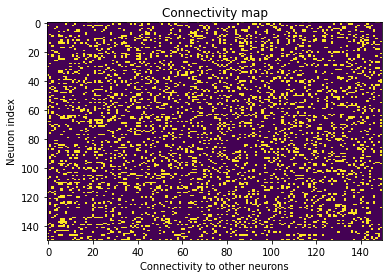

In [ ]:
plot_connectivity(LIF)

The simulation can run for an alloted period of time using LIF.simulate(). Here, we run the simulation for 100 milliseconds and plot the voltages for 10 of the neurons with plot_voltage(). Not that if you repeat this process, that time continues from the end of the last simulation.

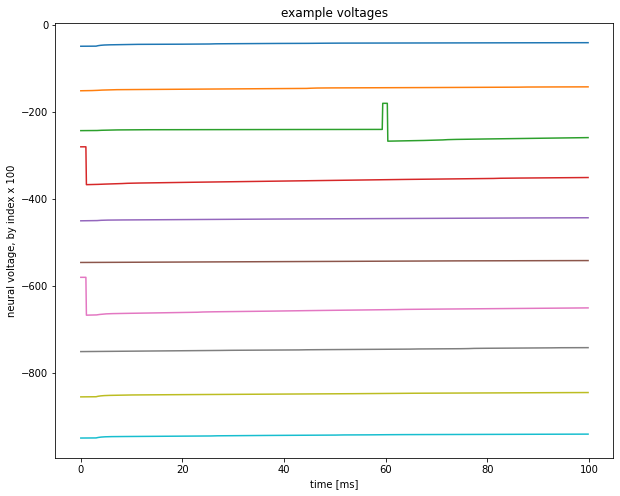

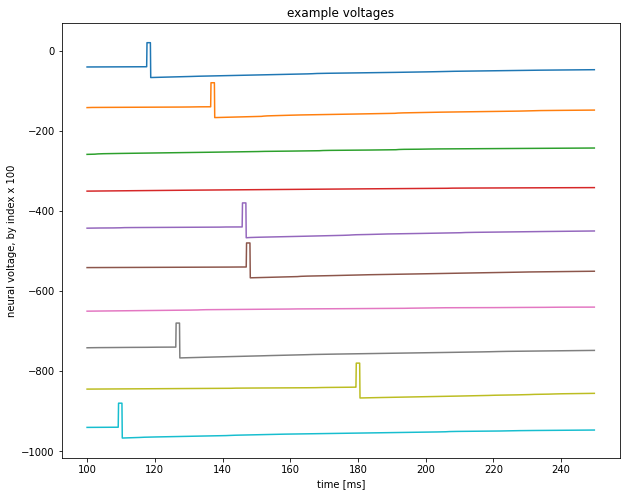

In [ ]:
LIF = LIF_Network(n_neurons=150, dimensions= [[0,100],[0,1],[0,1]])
LIF.p_conn = .5

simulation_results = LIF.simulate(timesteps = 100)
plot_voltage(simulation_results, n = 10)

simulation_results = LIF.simulate(timesteps = 150)
plot_voltage(simulation_results, n = 10)

You can also view the spike train by calling the internal function LIF.spikeTrain().

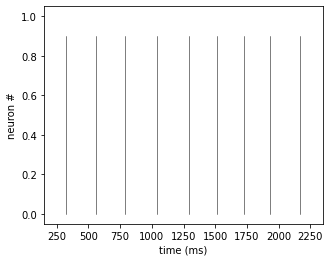

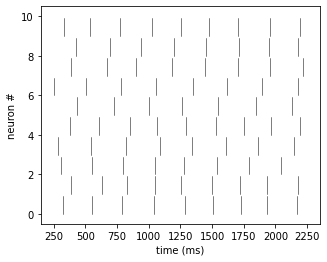

[[ 146.   251.7]
 [  41.   251.8]
 [   6.   254.2]
 ...
 [  16.  2239.5]
 [  23.  2239.9]
 [ 113.  2242.6]]


In [ ]:
h = LIF.simulate(timesteps = 2000)
st1 = LIF.spikeTrain(lookBack=2000,nNeurons=1)
st2 = LIF.spikeTrain(lookBack=2000,nNeurons=10)

print(st2)

You can observe the degree of synchrony in the network using Kuramato's method, which is called with the internal class function kuramato(). Below shows the change in synchrony as the network weights increase across 5000 milliseconds. The network is completely disconnected at the 5000 ms mark and the order paramter decreases afterwards as a result. The degree of synchrony can be observed using the Kuramato order metric, but it can also be seen in the spike train for visualization reference and validation.

Starting...
Running Synchrony...
 ___________________
[███████████████████] Done!

Phase ended at time: 5000.0000000006585 ms.
Running desynchrony... 
 _________
[█████████] Done!
Phase ended at time: 7000.000000007934 ms.


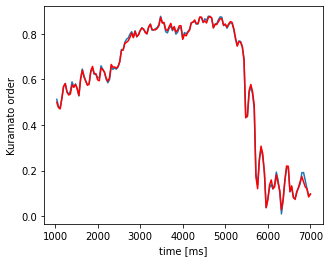

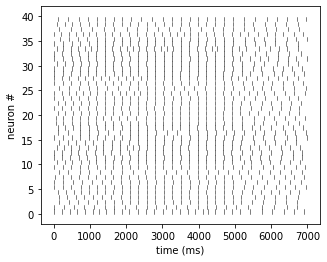

In [ ]:
np.random.seed(1)
LIF = LIF_Network(n_neurons= 200)
LIF.p_conn = .1
LIF.random_conn()

t = []
o = []
ov = []
splits = 5
trials = 20*splits
LB = 1000
LIF.simulate(timesteps = LB)
print("Starting...")
print("Running Synchrony...")
print(" ",end = "")
print("_"*int(-1+trials/splits))
print("[", end="")
for i in range(trials):
  h = LIF.simulate(timesteps = 200/splits)
  ordv = LIF.vect_kuramato(period = 200, lookBack = LB, r_cutoff = .1)
  ord = LIF.kuramato(period = 200, lookBack = LB)
  t.append(LIF.t)
  o.append(ord)
  ov.append(ordv)
  if i%splits == 0 and i > 1:
    print("█",end="")
print("] Done!")

print("")
print("Phase ended at time: " + str(LIF.t) + " ms.")

# Reset network to 0 connectivity:
LIF.network_conn = np.zeros([LIF.n_neurons,LIF.n_neurons])  
LIF.g_poisson = 3
trials = 10*splits
print("Running desynchrony... ")
print(" ",end = "")
print("_"*int(-1+trials/splits))
print("[", end="")
for i in range(trials):
  h = LIF.simulate(timesteps = 200/splits)
  ordv = LIF.vect_kuramato(period = 200, lookBack = LB, r_cutoff = .1)
  ord = LIF.kuramato(period = 200, lookBack = LB)
  t.append(LIF.t)
  o.append(ord)
  ov.append(ordv)
  if i%splits == 0 and i > 1:
    print("█",end="")
print("] Done!")
print("Phase ended at time: " + str(LIF.t) + " ms.")

%matplotlib inline
fig = plt.figure()

plt.xlabel('time [ms]')
plt.ylabel('Kuramato order')
plt.plot(t,o)
plt.plot(t,ov,'red')
fig.set_size_inches(5, 4)
plt.show()

rr = LIF.spikeTrain(nNeurons=40,purge=False)

We can view our STDP function by running assaySTDP() on the LIF class:

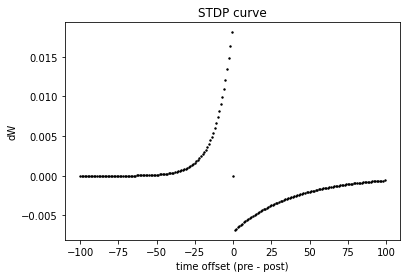

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.assaySTDP()

Let's examine a very small network so we can observe the STDP events and line them up with spiking events. This will help us verify that the learning rule is working as we expect it to:

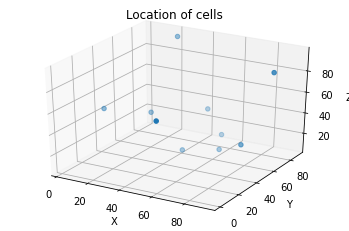

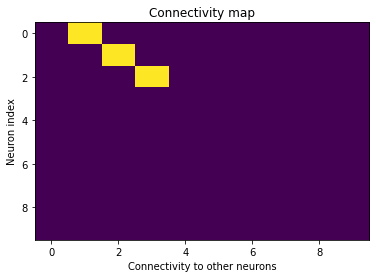

0.03


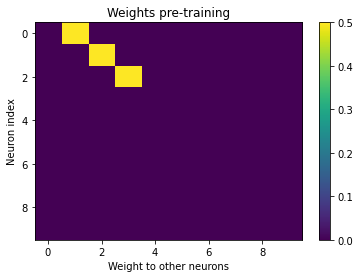

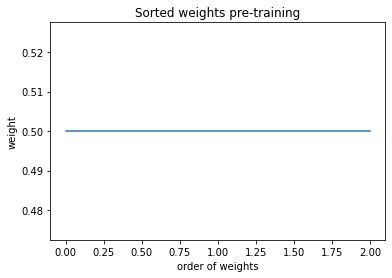

0.5


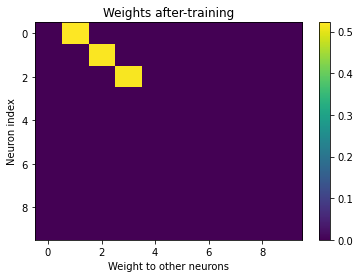

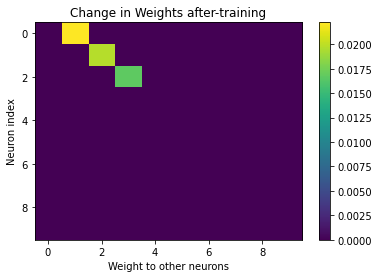

0.5195815011517798


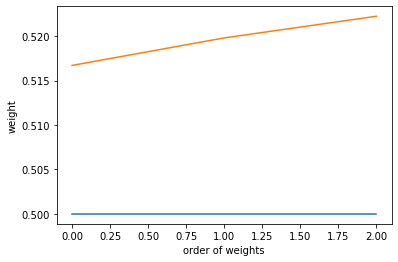

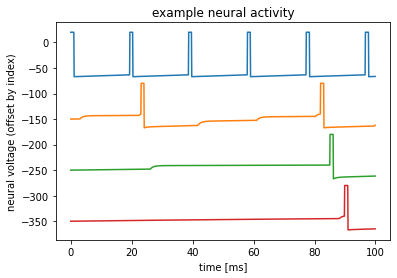

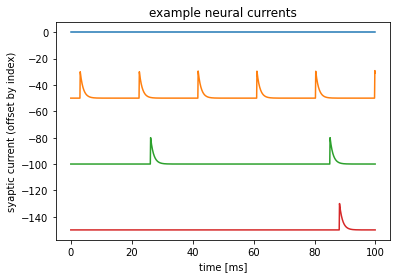

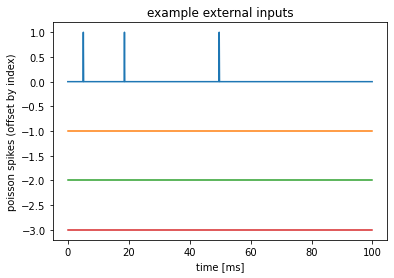

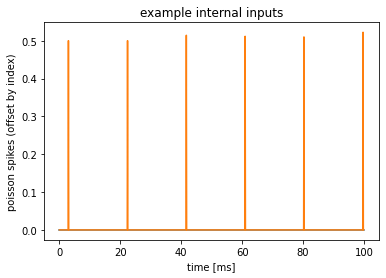

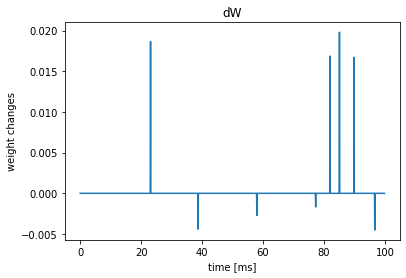

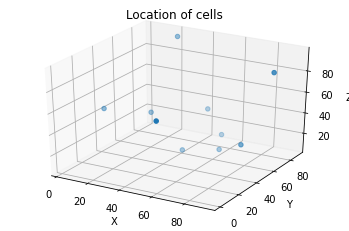

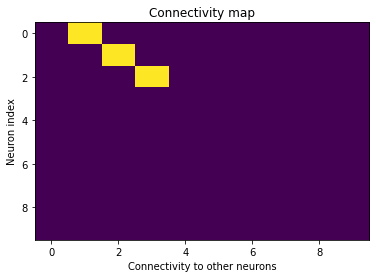

0.03


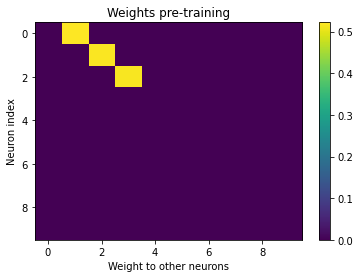

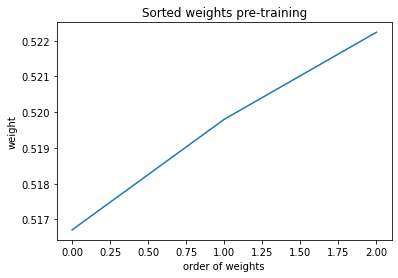

0.5195815011517798


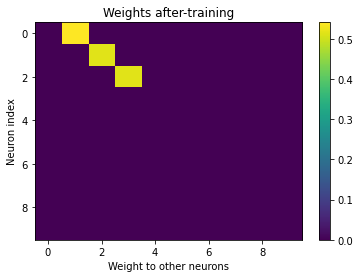

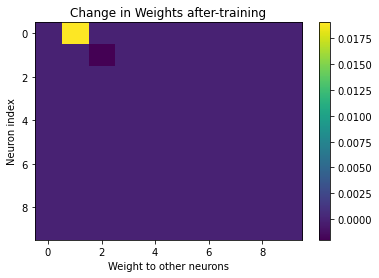

0.5252651921617578


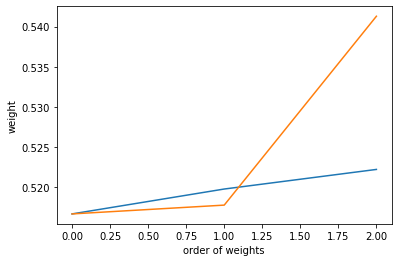

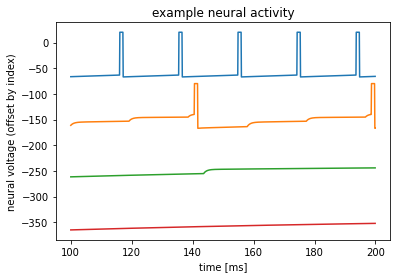

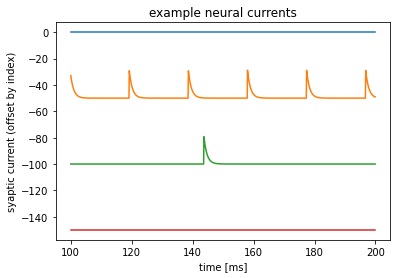

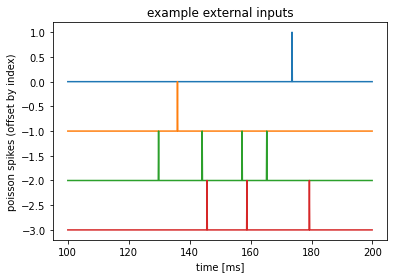

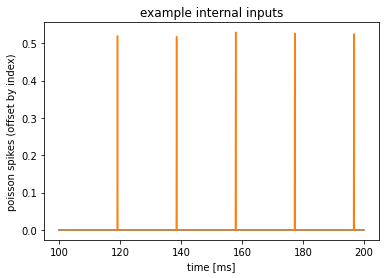

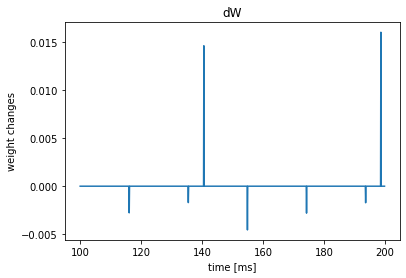

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,4):
  LIF.network_conn[i-1][i] = 1
  LIF.network_W[i-1][i] = .5

LIF.g_poisson = 0
print(LIF)

plotter(LIF,100,pN = 4)
plotter(LIF,100,pN = 4)

Here, because we 'purged' the spike record, everything before the epoch has been forgotten. So be careful! The spike record is memory intensive, so it should be purged periodically, but you should save it somewhere. The function returns the spike record, as you can see.

Now let's see if we can observe synchrony in the spikes:

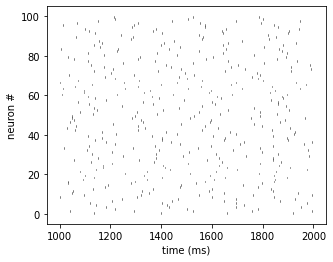

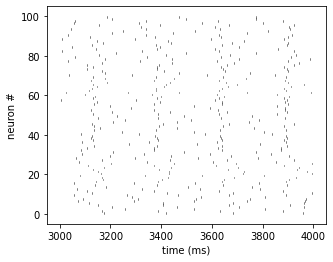

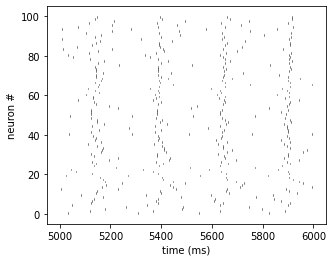

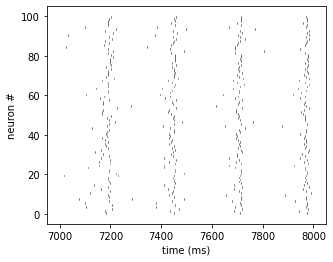

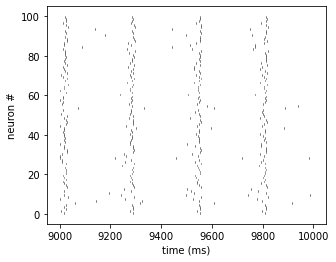

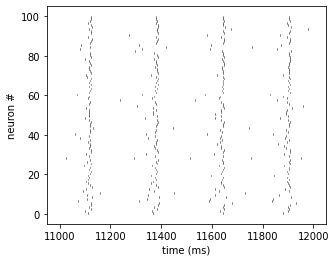

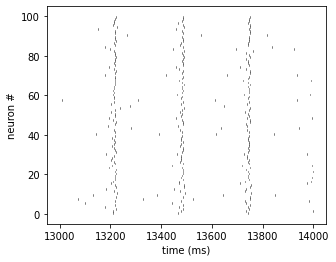

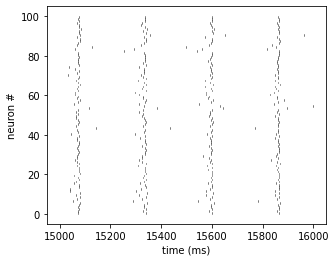

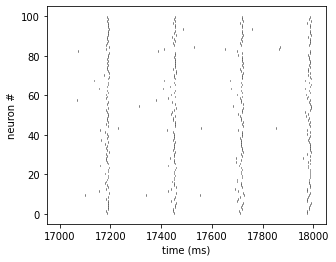

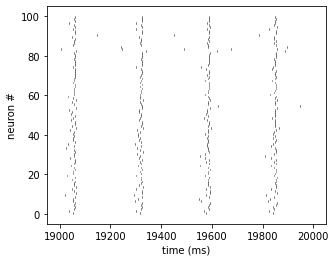

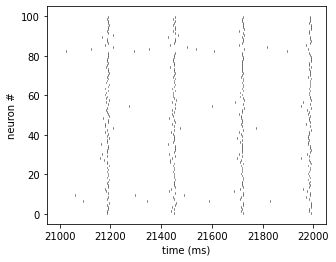

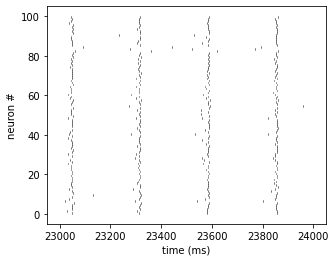

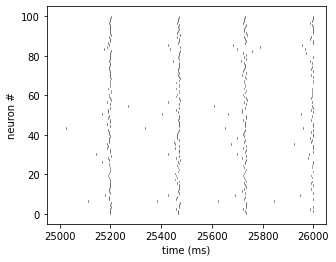

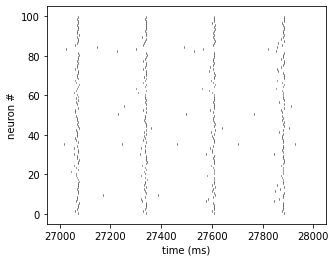

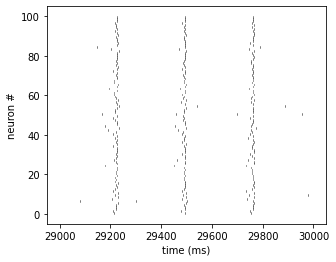

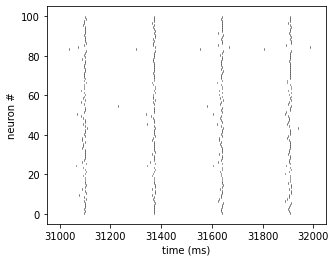

In [ ]:
LIF = LIF_Network(n_neurons=300)

h = LIF.simulate(timesteps = 2000)
[v,g,p,t,inp,dw] = h
h2 = LIF.spikeTrain(lookBack=1000,nNeurons=100,purge=False)

for i in range(15):
  h = LIF.simulate(timesteps = 2000)
  [v,g,p,t,inp,dw] = h
  h2 = LIF.spikeTrain(lookBack=1000,nNeurons=100,purge=False)
  LIF.kuramato()
  

Great!

That seems reasonable. Now lets see what happens when when the first neuron is weakly connected to all other neurons. It should generate some negative plasticity because it is constatly firing without causing spikes in the post-synaptic cells:

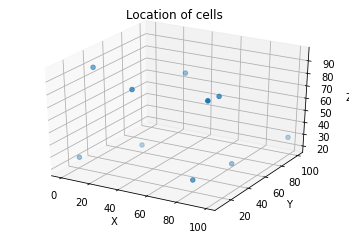

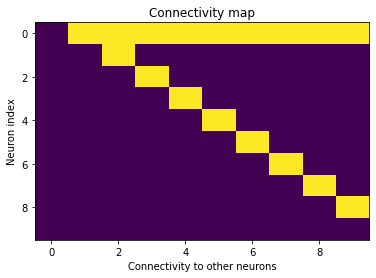

0.17


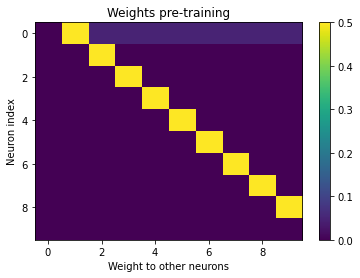

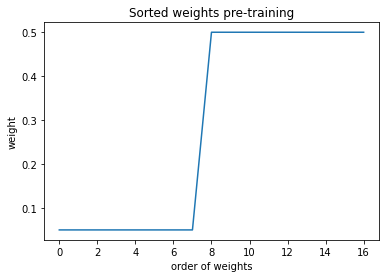

0.2882352941176471


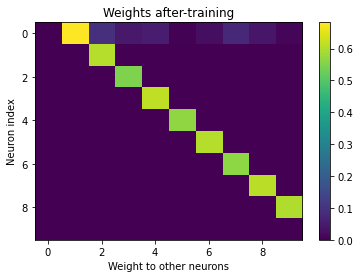

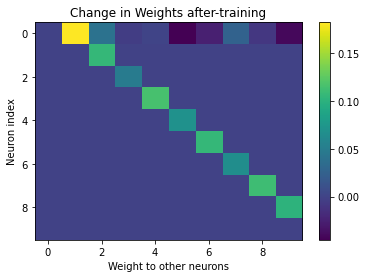

0.33864971926591547


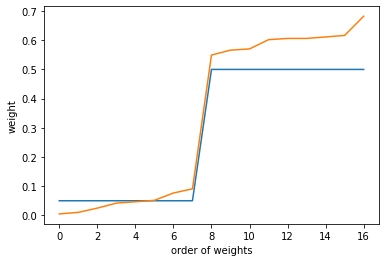

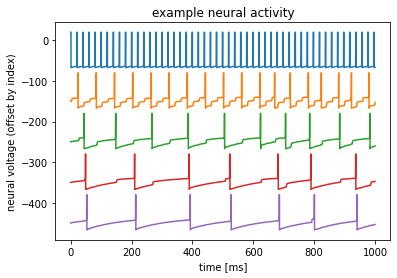

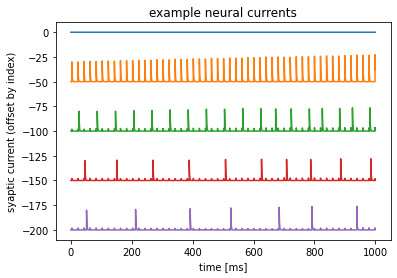

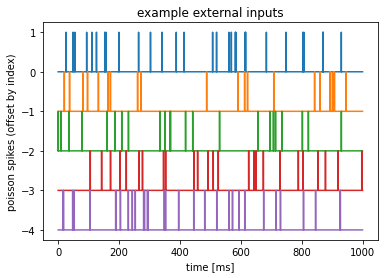

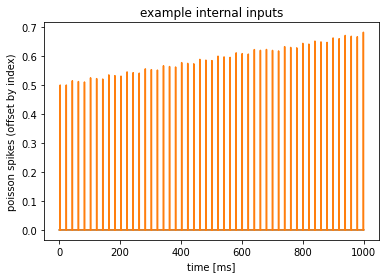

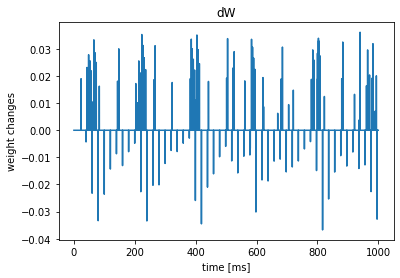

In [ ]:
LIF = LIF_Network(n_neurons=10)

LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,10):
  LIF.network_conn[i-1][i] = 1
  LIF.network_conn[0][i] = 1
  LIF.network_W[i-1][i] = .5
  LIF.network_W[0][i] = .05
LIF.network_W[0][1] = .5 
LIF.network_W[0][0] = 0
LIF.g_poisson = 0
print(LIF)

plotter(LIF,1000)

We see a train of negative weight updates alligned with the firing of cell one. Let's now examine how Beta affects the learning curve, and then try out a LTP biased system vs a LTP biased system:

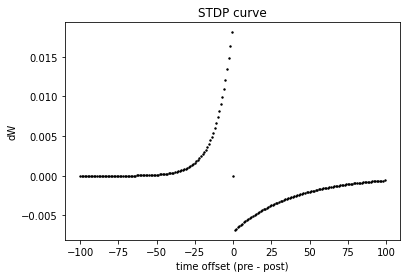

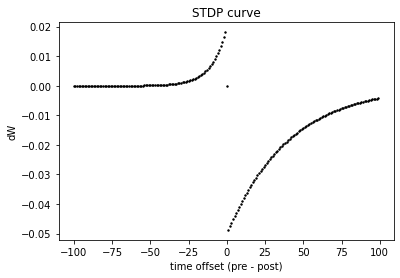

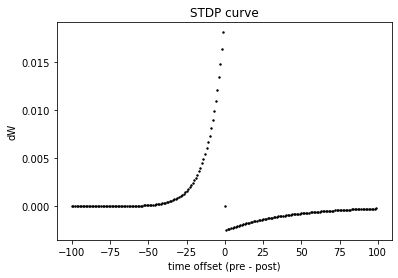

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.assaySTDP()

LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = 10
LIF.assaySTDP()

LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = .5
LIF.assaySTDP()


We can see that beta affects the magnitude of LTP, so let's see what happens when beta is small:

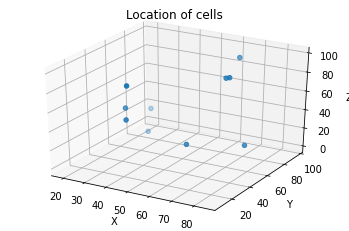

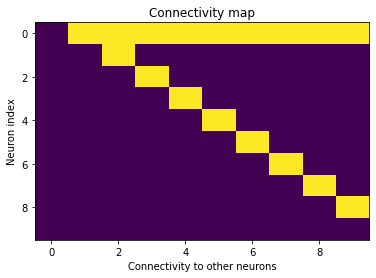

0.17


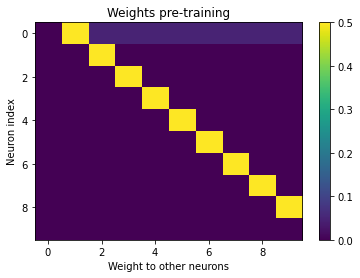

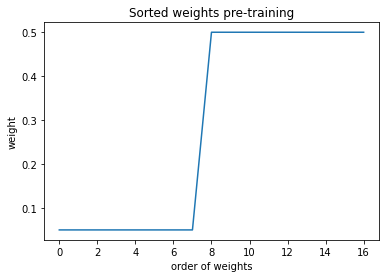

0.2882352941176471


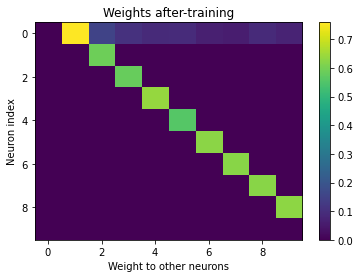

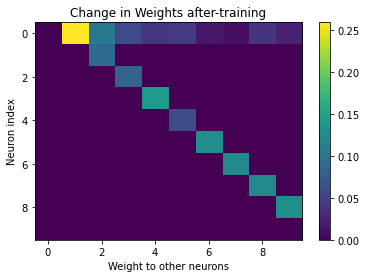

0.3747795713709793


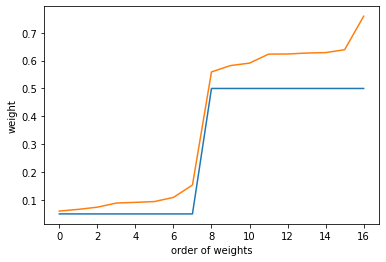

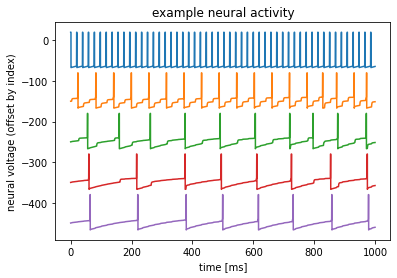

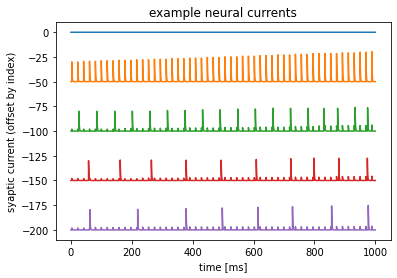

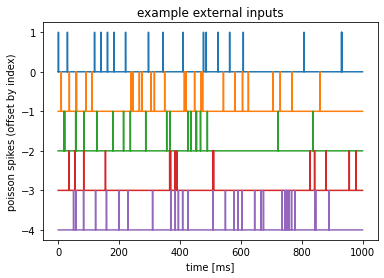

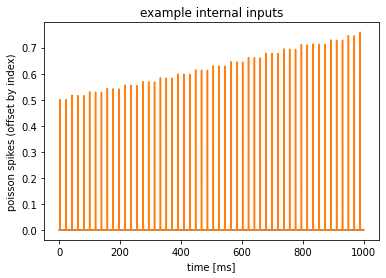

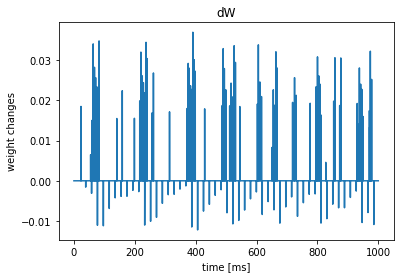

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = .5

LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,10):
  LIF.network_conn[i-1][i] = 1
  LIF.network_conn[0][i] = 1
  LIF.network_W[i-1][i] = .5
  LIF.network_W[0][i] = .05
  
LIF.network_W[0][1] = .5 
LIF.network_W[0][0] = 0
LIF.g_poisson = 0

plotter(LIF,1000)

Even though cell one is not contributing to firing in cells 2-10, it still undergoes LTP because of the learning bias.

Now let's see what happens when beta is large, meaning that LTD is favored:

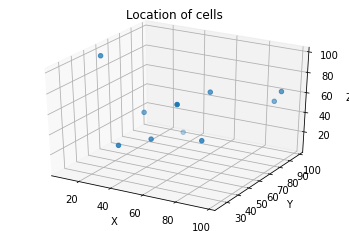

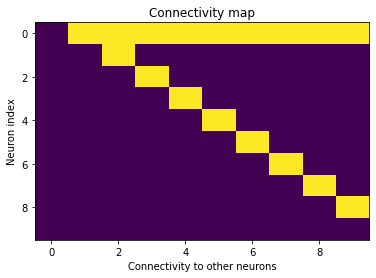

0.17


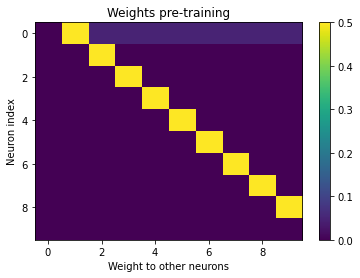

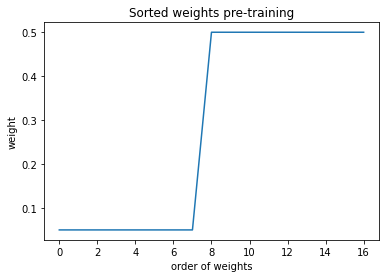

0.2882352941176471


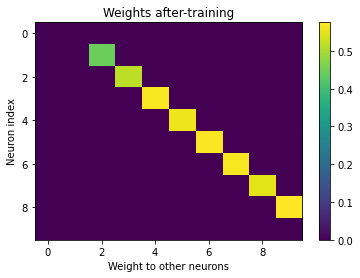

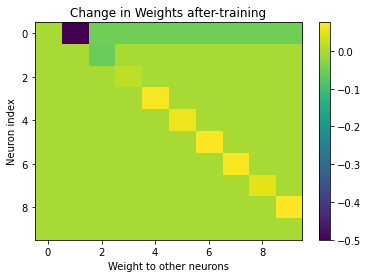

0.5455723604537936


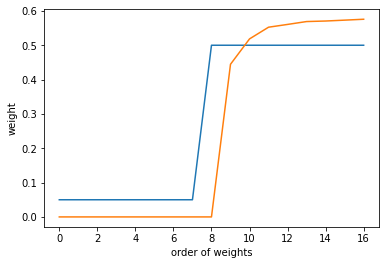

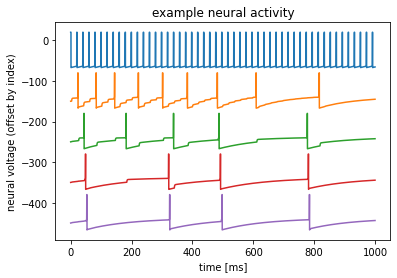

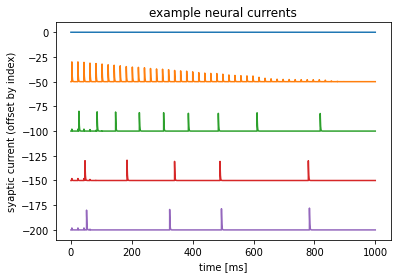

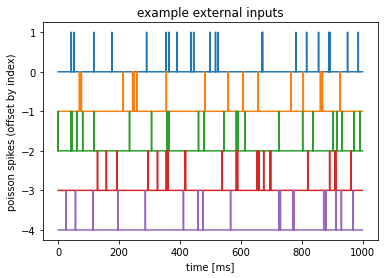

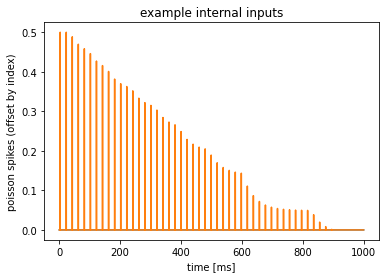

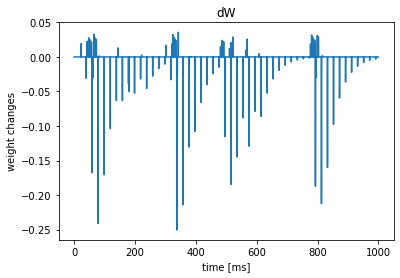

In [ ]:
LIF = LIF_Network(n_neurons=10)
LIF.stdp_beta = 10

LIF.v = LIF.v * 0 - 50
LIF.v_thr[0] = -70
LIF.v_rf_thr[0] = -65

LIF.network_conn = LIF.network_conn * 0
LIF.network_W = LIF.network_W * 0
for i in range(1,10):
  LIF.network_conn[i-1][i] = 1
  LIF.network_conn[0][i] = 1
  LIF.network_W[i-1][i] = .5
  LIF.network_W[0][i] = .05
  
LIF.network_W[0][1] = .5 
LIF.network_W[0][0] = 0
LIF.g_poisson = 0

plotter(LIF,1000)

Looks like we see a massive decrease in weights across the board, as expected.


Let's now use a more realistic network and run it for 20 seconds to see if we see an overall increase in weights.

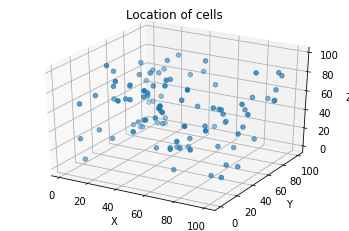

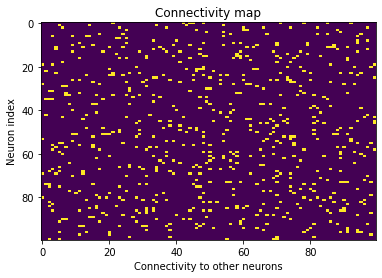

0.066


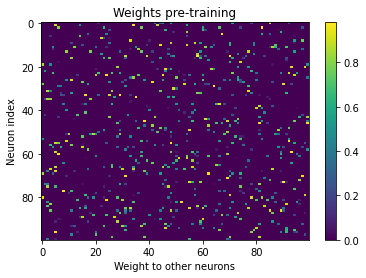

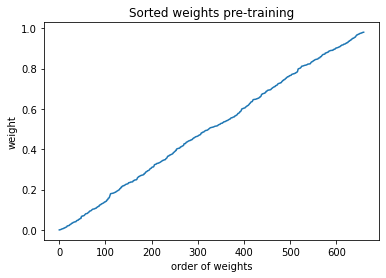

0.5


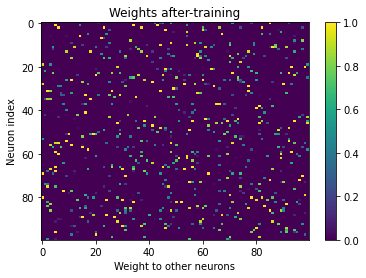

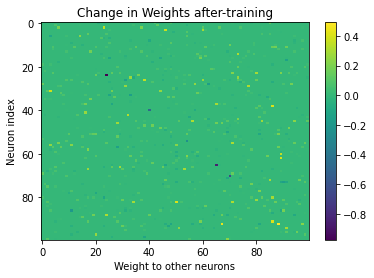

0.5586374346380528


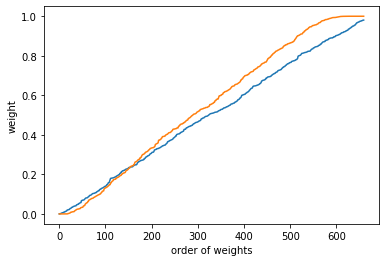

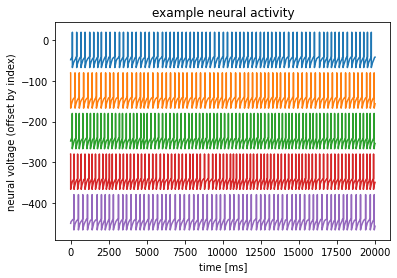

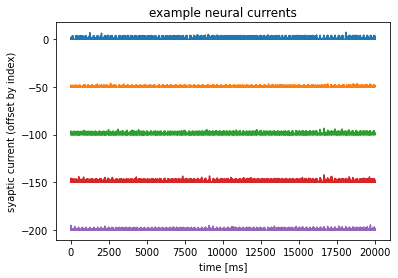

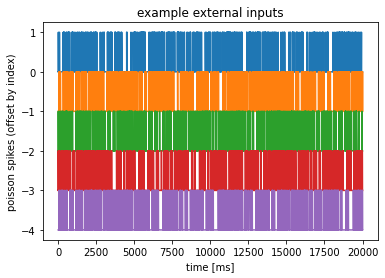

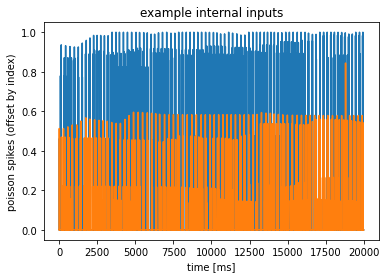

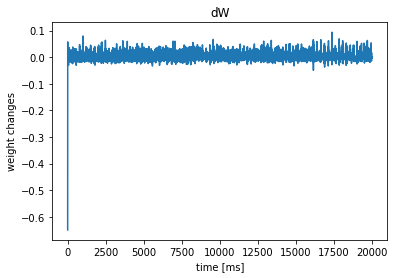

In [ ]:
LIF = LIF_Network(n_neurons= 100)
plotter(LIF,20000)

Seems like there is an overall trend towards increased weights between connected neurons, though some weakly connected neurons seem to be eliminating their weights too.

## Bistability of neural weights and synchrony

This model shows the different results for the weights and the orders of the neurons, both in graph and matrix form. The graphs show for each pixel fo the matrix and the behavior of the network over time. The matrix shows the results after a set period of time. Each pixel represents a network being stimulated with a different frequency and number of fingers (stimulation nodes). The colormap shows either the weights or the order of the neurons in each network.

In [ ]:
#@title Plotting function 2
def plotter2(LIF,time,I,pN = 5):

  LIF.simulate(timesteps = time,I=I)
  #[v,g,p,t,inp,dw] = h
  W2 = LIF.network_W

  %matplotlib inline
  fig = plt.figure()
  #for i in range(pN):
    #plt.plot(t,g[:,i]-i*50)
  #plt.xlabel('time [ms]')
  #plt.ylabel('syaptic current (offset by index)')
  #plt.title('example neural currents')
  #plt.show()

The following cell shows the results of the weight after every 2 seconds. The number of fingers is 10 and the frequency is 50. These parameters can be changed to see different results.

The results of this cell as it is are that the weights and the order increase overall logarthimically.

0


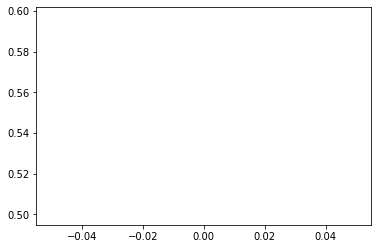

1


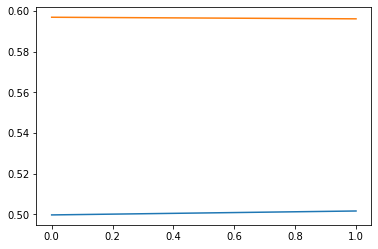

2


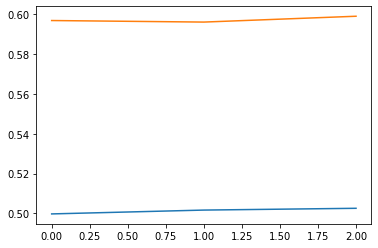

3


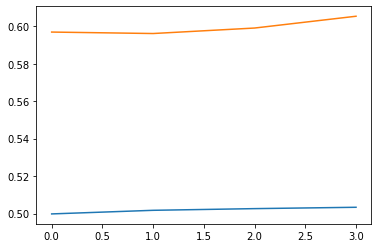

4


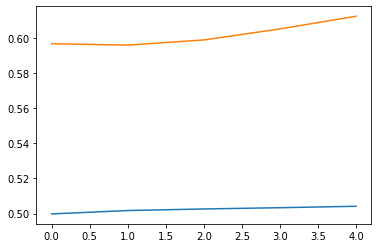

5


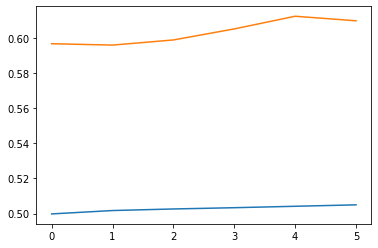

6


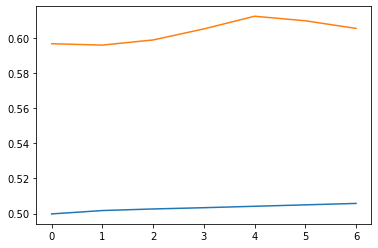

7


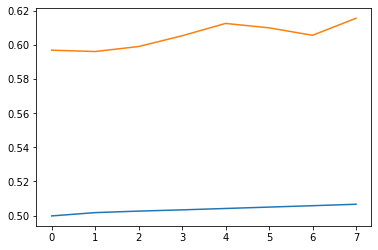

8


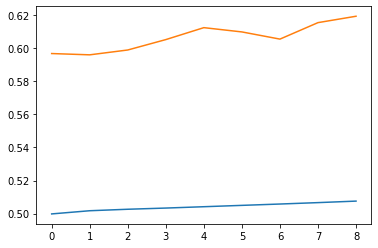

9


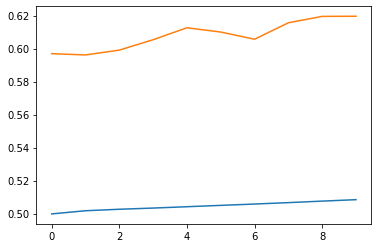

10


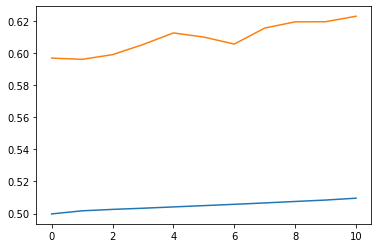

11


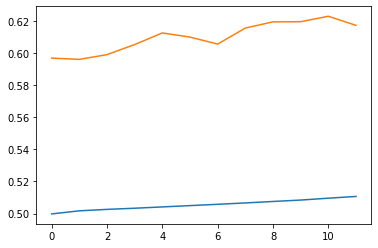

12


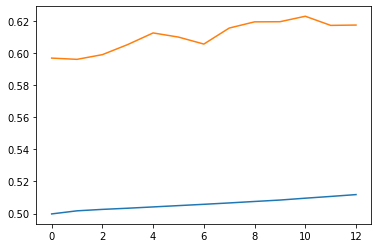

13


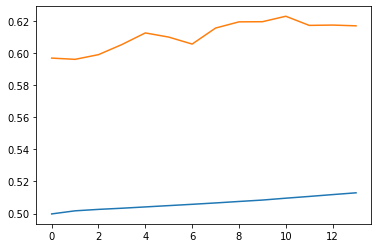

14


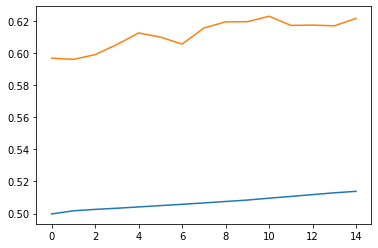

15


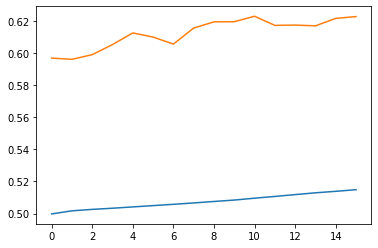

16


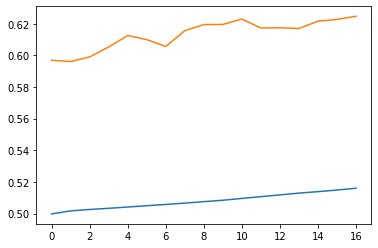

17


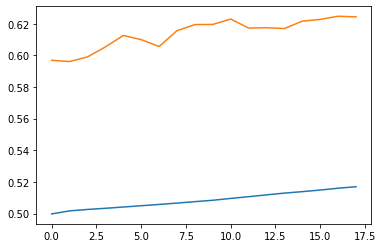

18


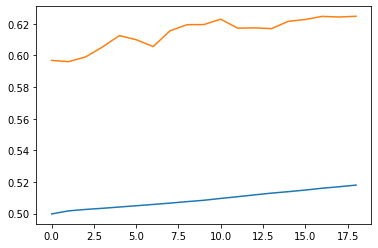

19


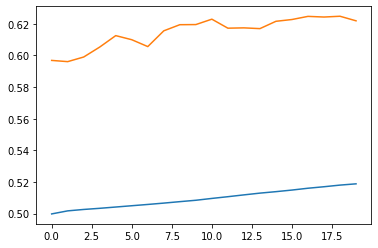

20


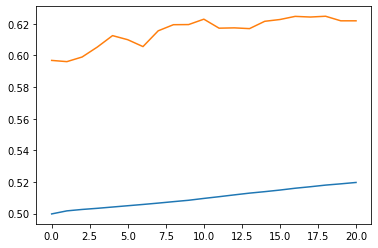

21


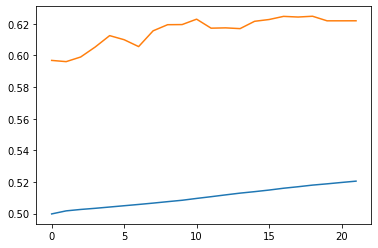

22


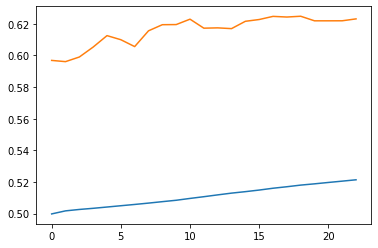

23


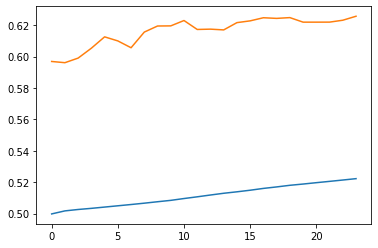

24


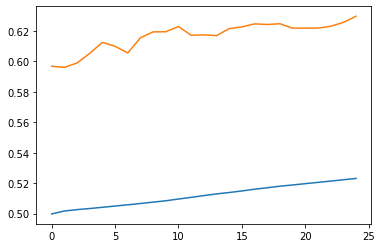

25


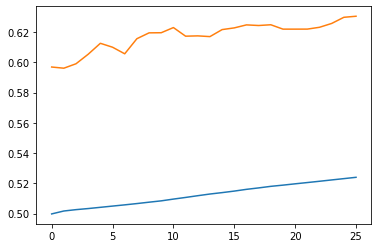

26


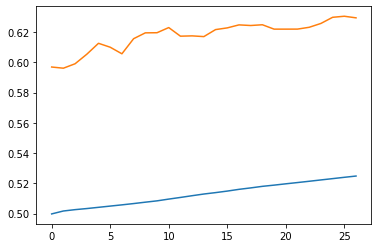

27


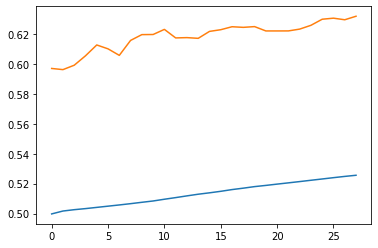

28


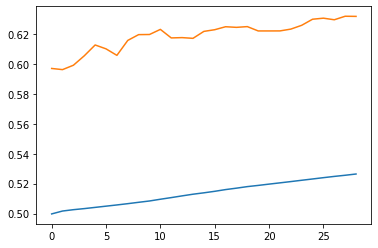

29


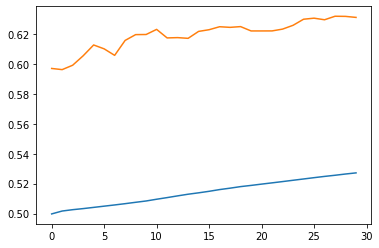

30


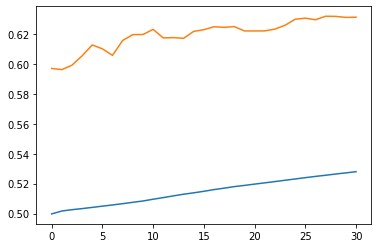

31


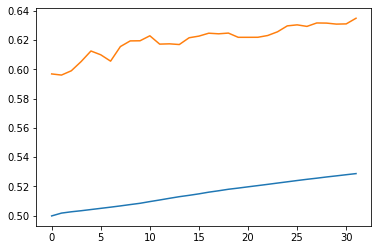

32


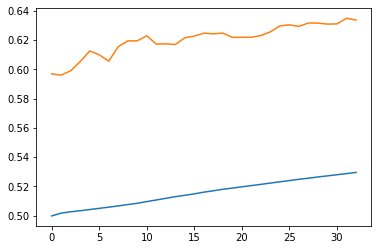

33


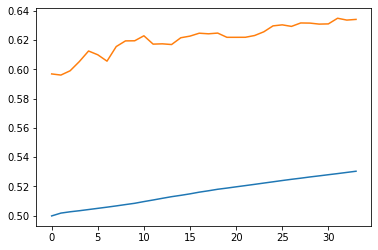

34


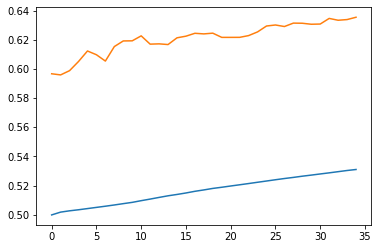

35


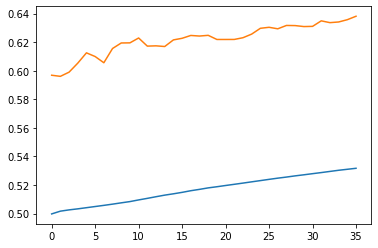

36


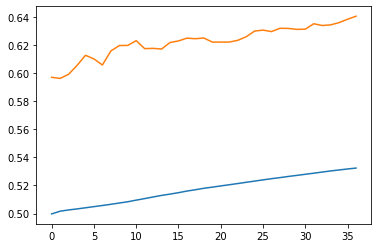

37


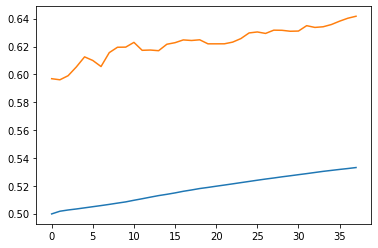

38


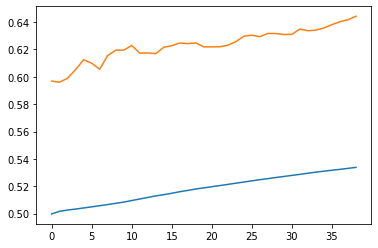

39


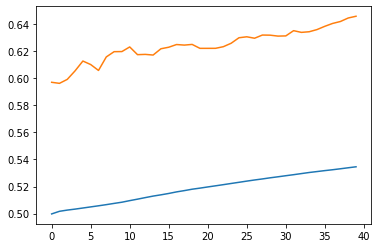

40


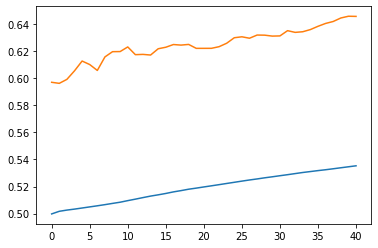

41


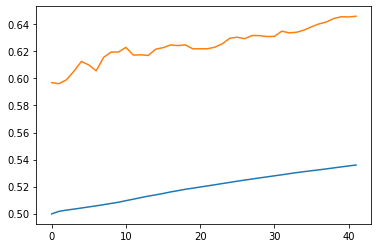

42


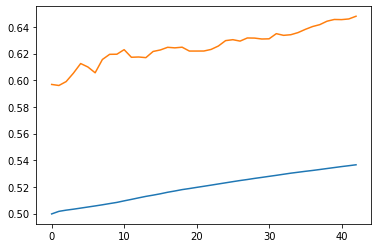

43


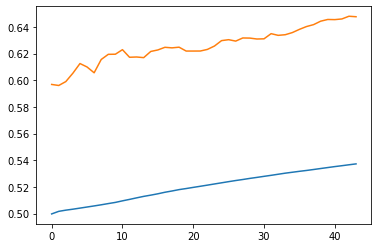

44


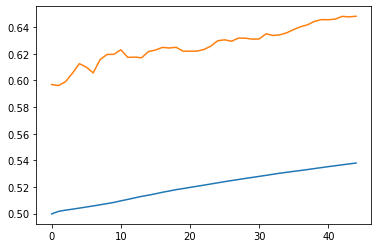

45


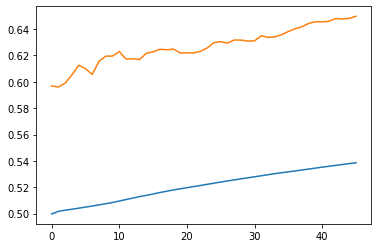

46


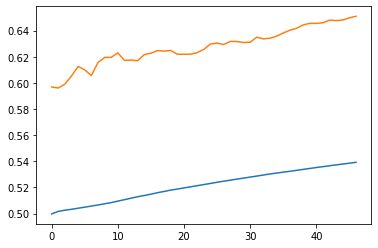

47


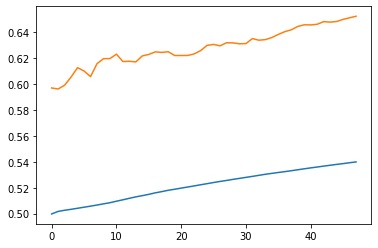

48


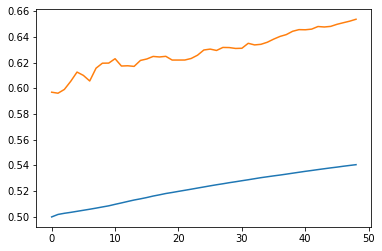

49


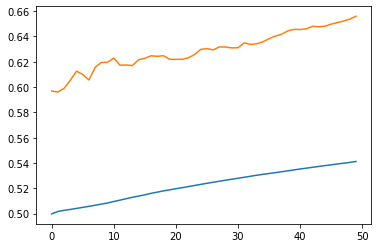

50


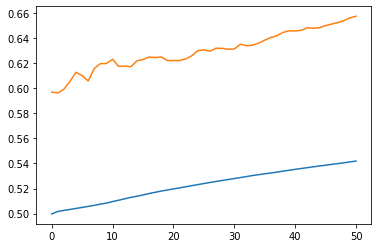

51


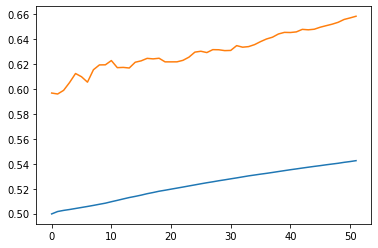

52


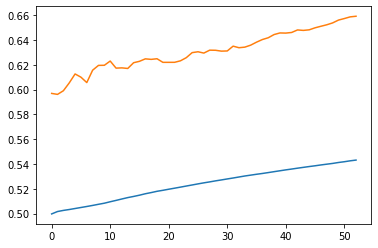

53


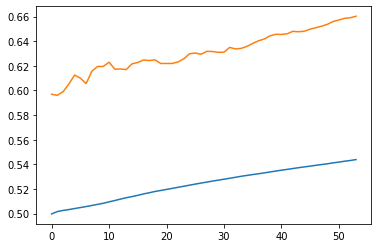

54


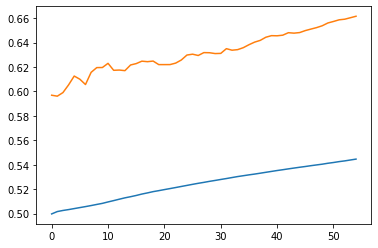

55


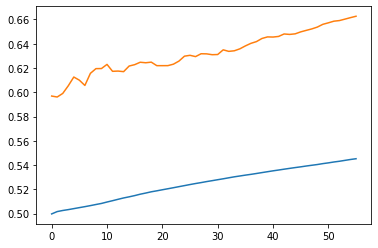

56


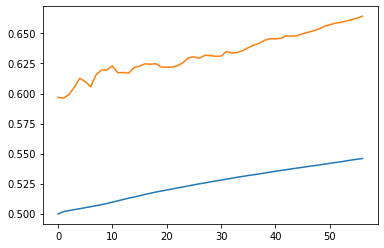

57


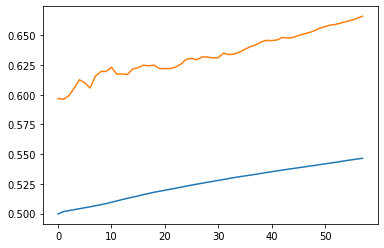

58


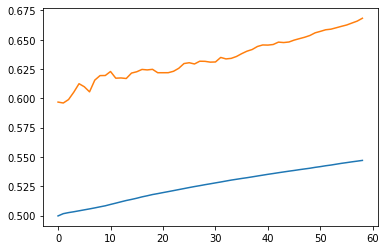

59


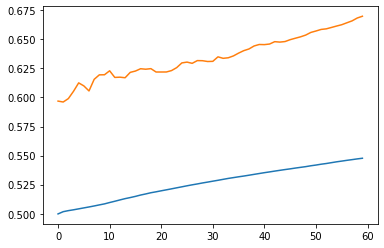

60


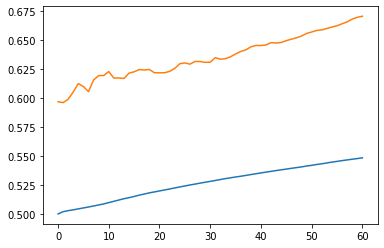

61


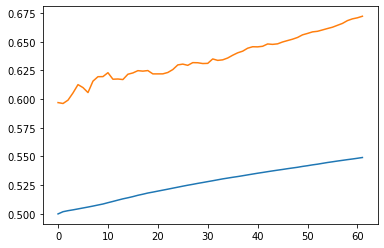

62


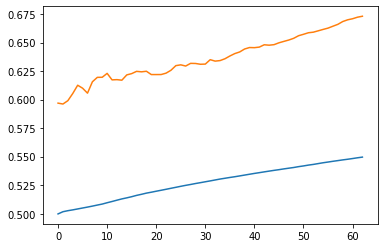

63


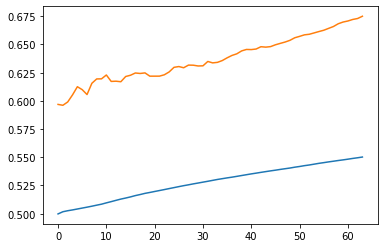

64


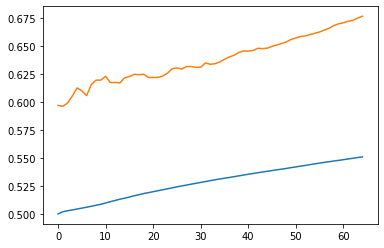

65


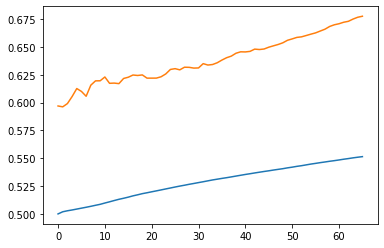

66


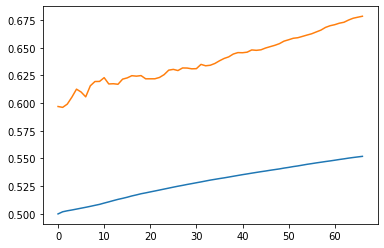

67


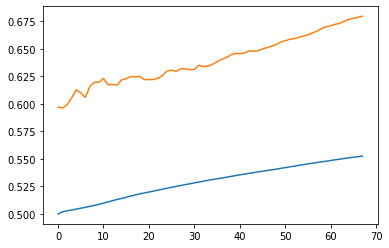

68


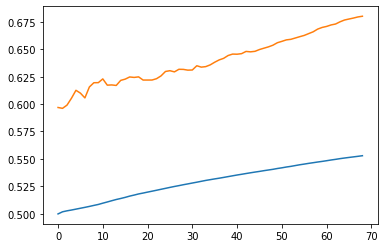

69


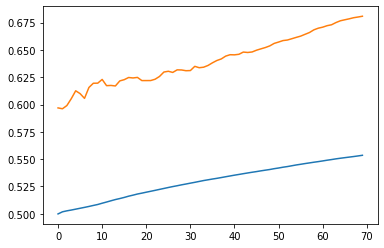

70


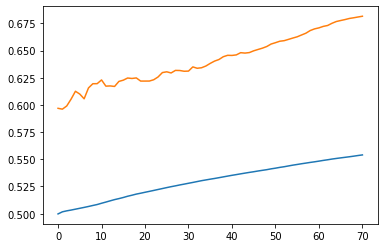

71


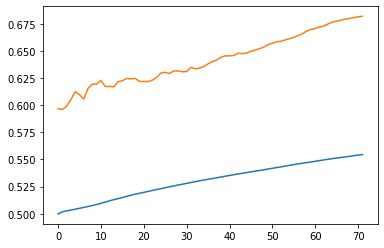

72


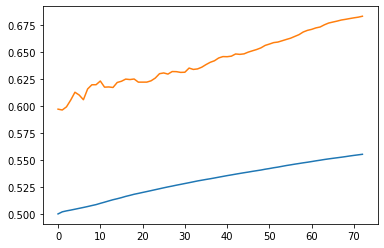

73


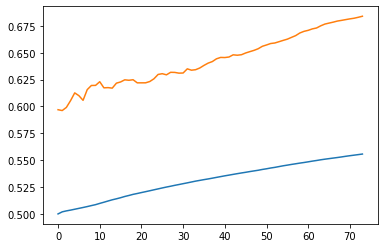

74


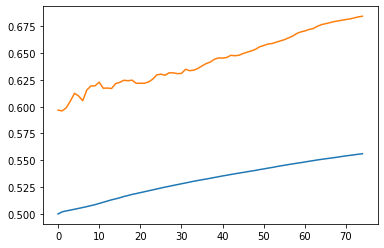

75


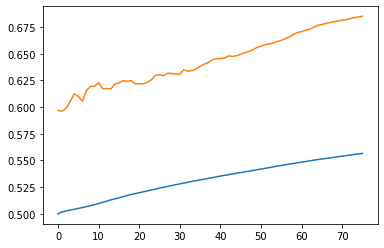

76


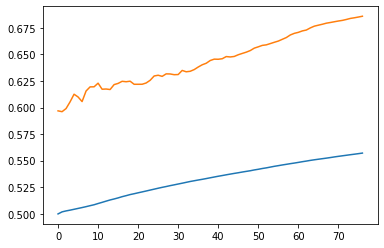

77


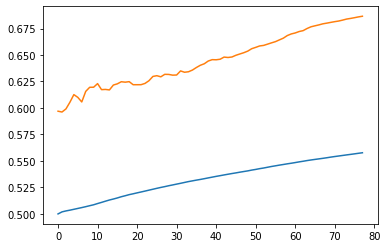

78


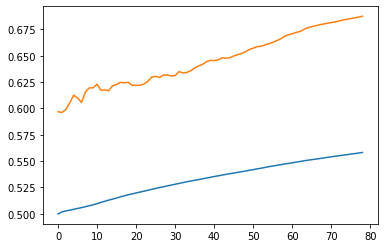

79


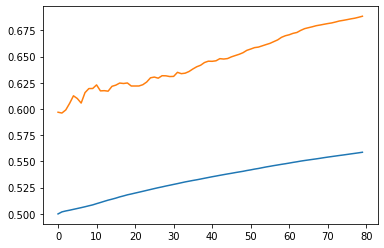

80


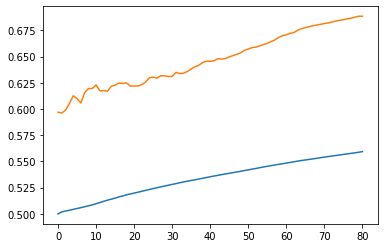

81


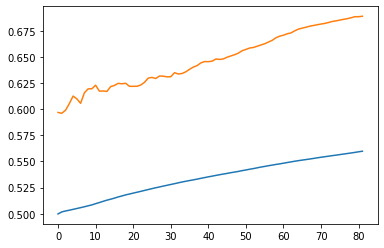

82


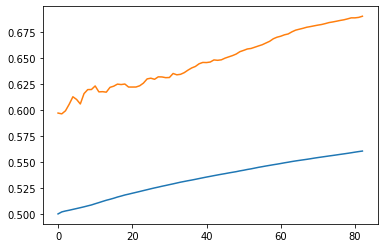

83


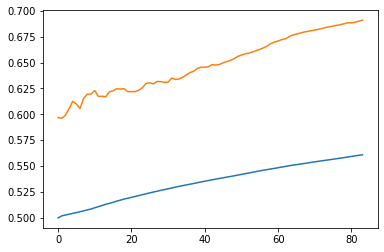

84


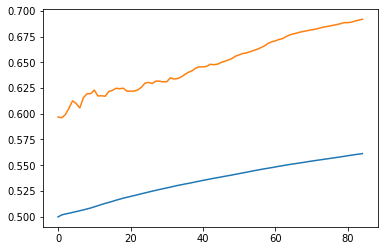

85


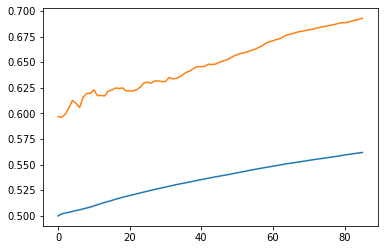

86


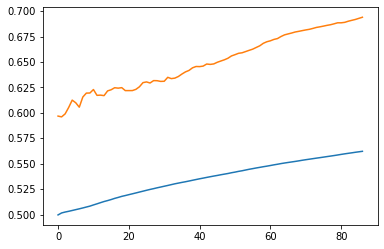

87


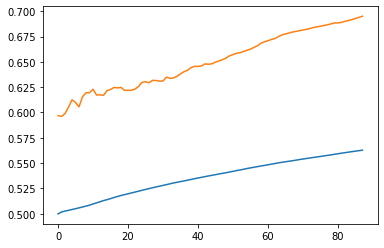

88


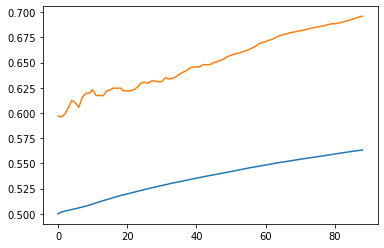

89


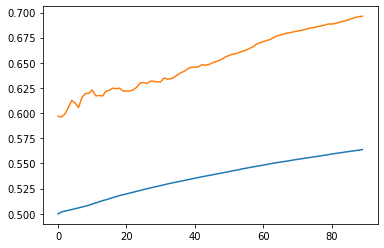

90


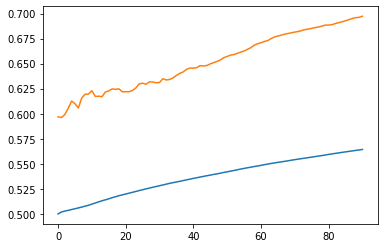

91


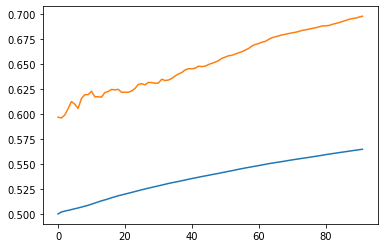

92


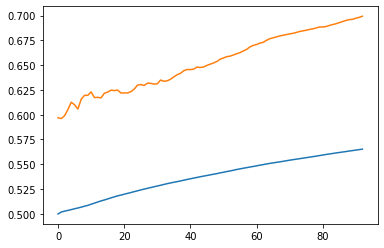

93


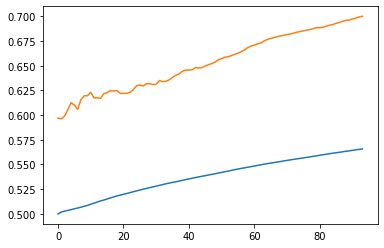

94


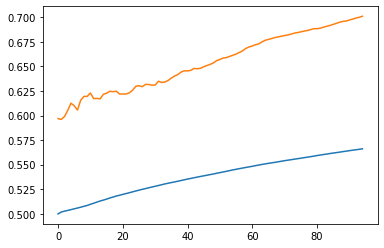

95


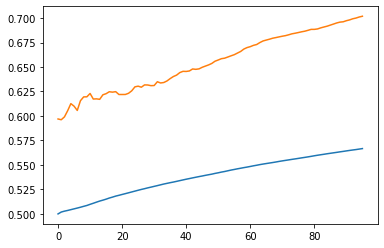

96


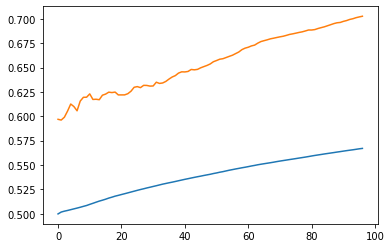

97


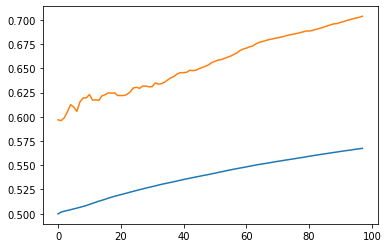

98


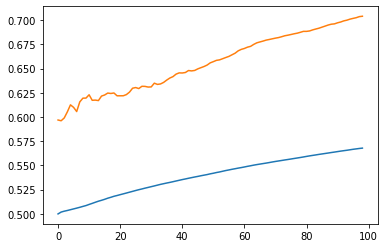

99


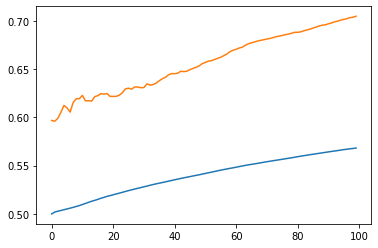

100


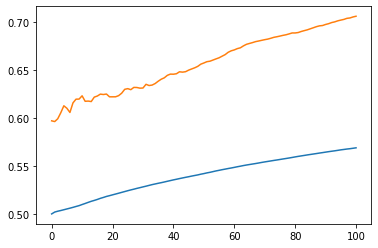

101


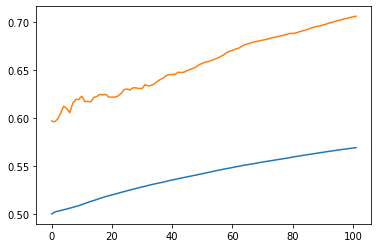

102


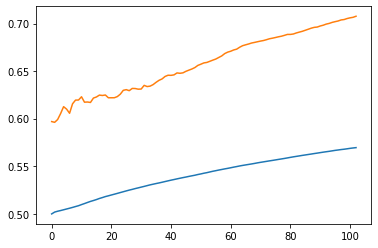

103


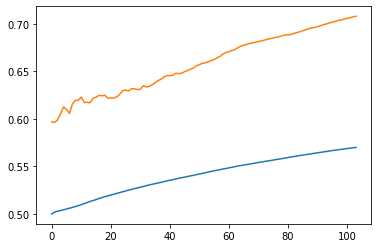

104


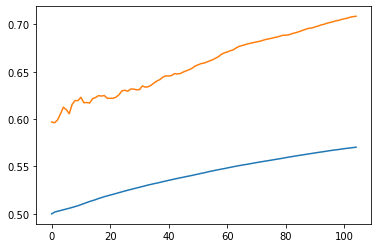

105


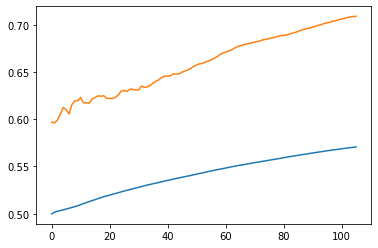

106


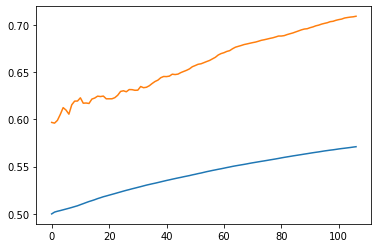

107


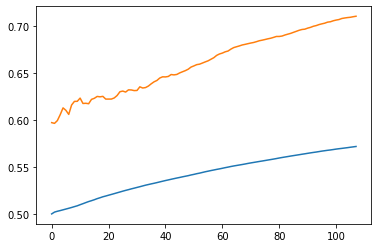

108


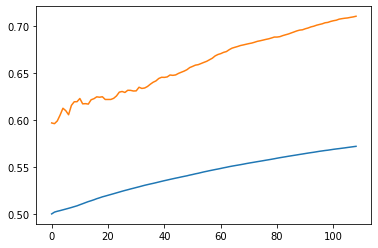

109


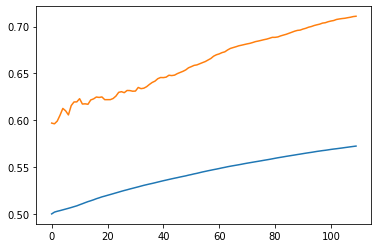

110


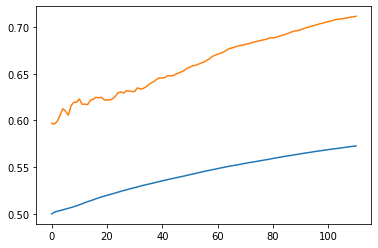

111


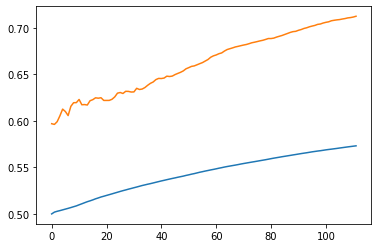

112


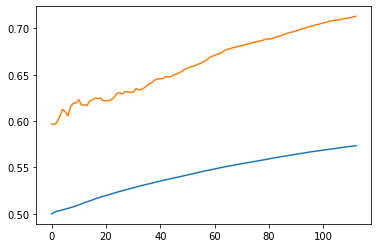

113


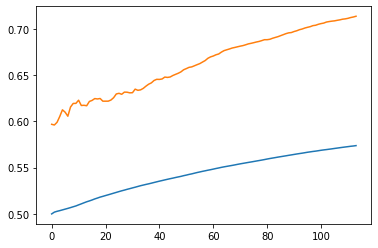

114


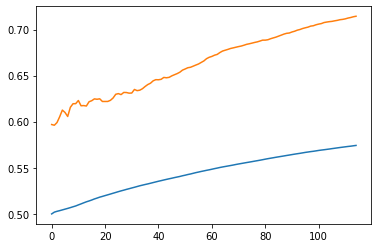

115


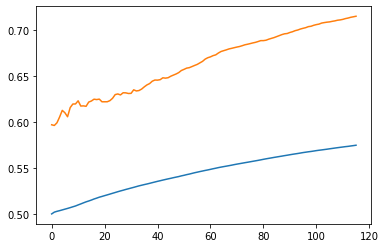

116


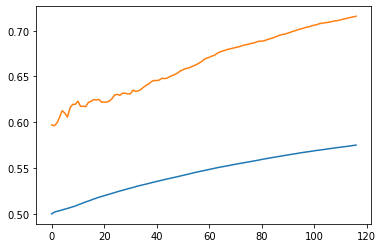

117


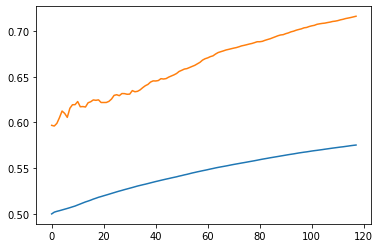

118


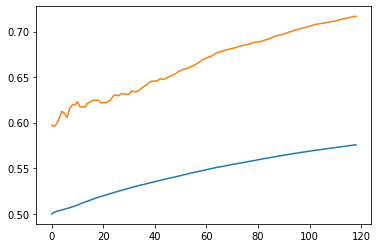

119


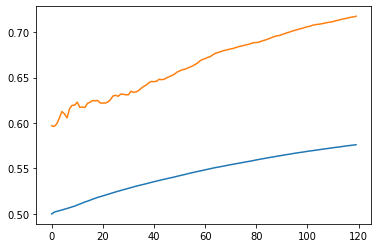

120


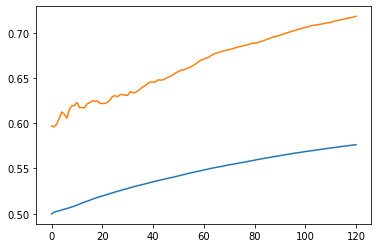

121


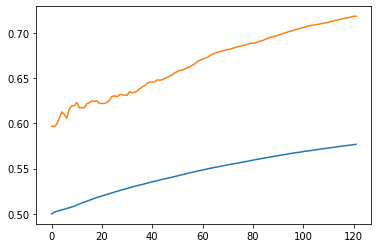

122


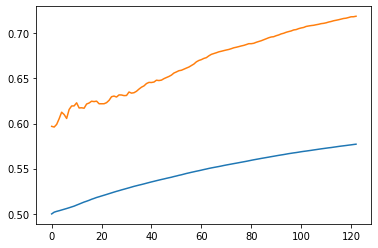

123


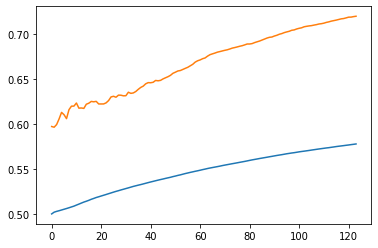

124


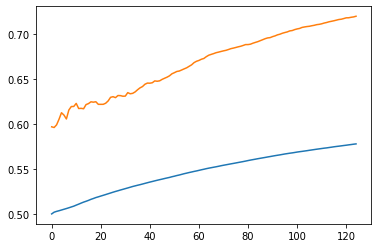

125


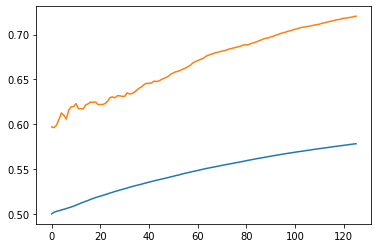

126


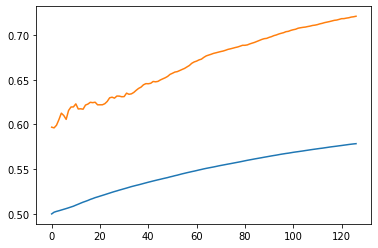

127


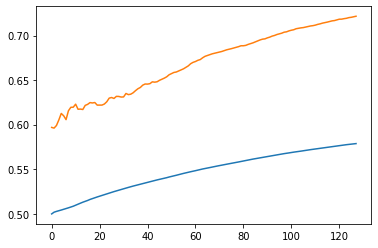

128


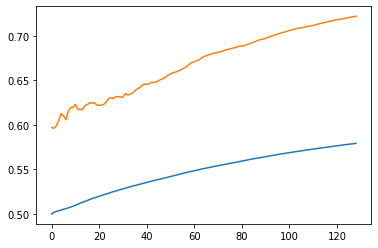

129


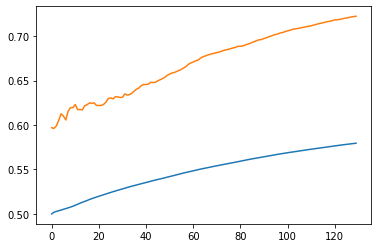

130


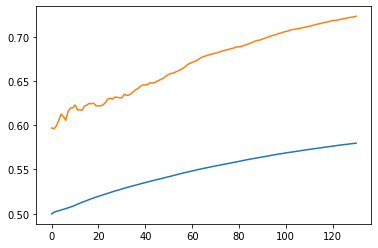

131


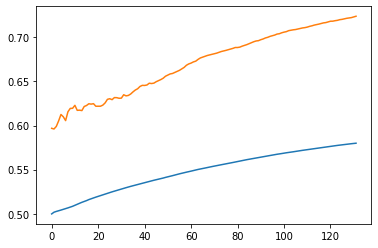

132


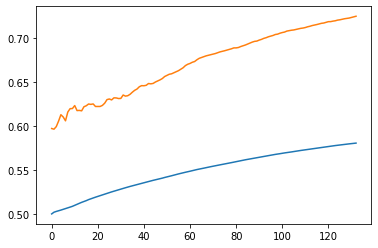

133


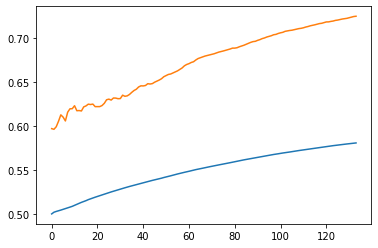

134


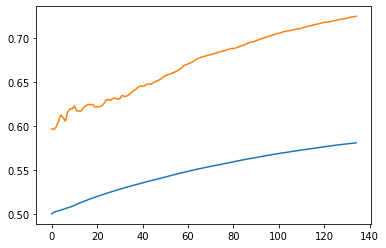

135


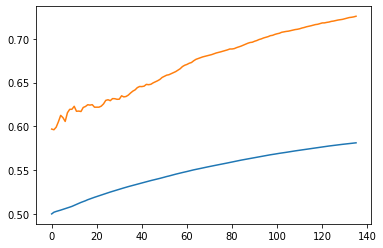

136


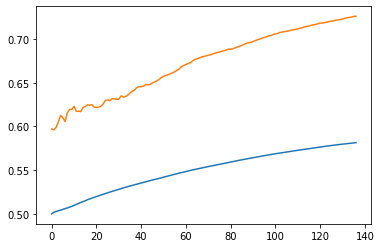

137


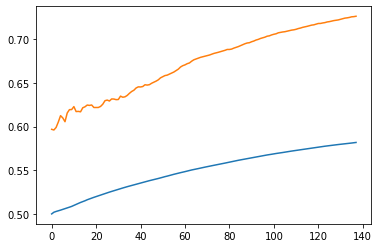

138


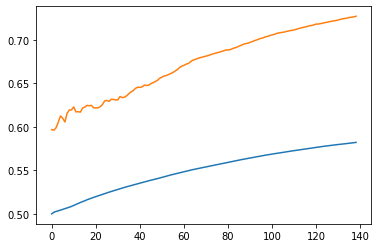

139


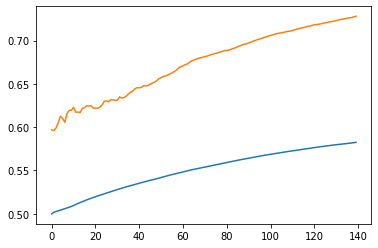

140


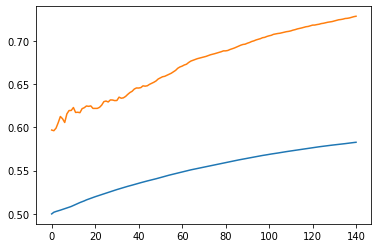

141


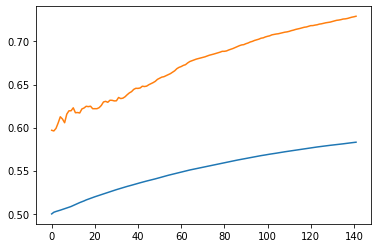

142


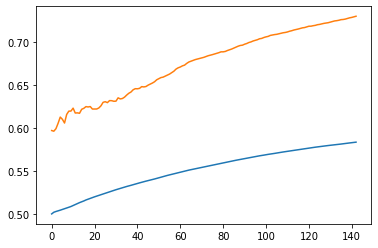

143


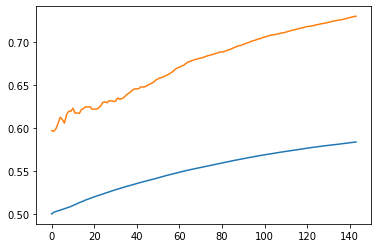

144


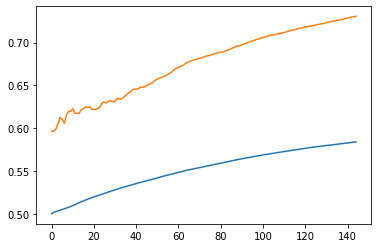

145


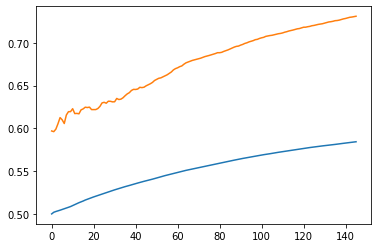

146


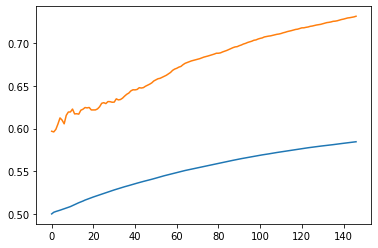

147


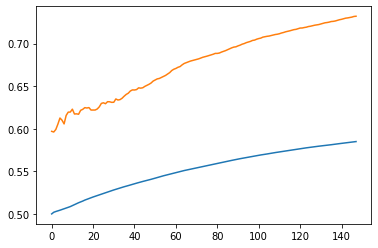

148


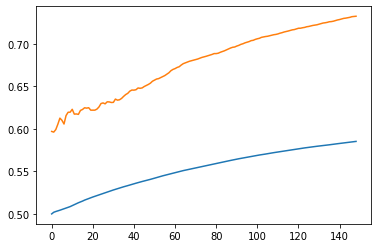

149


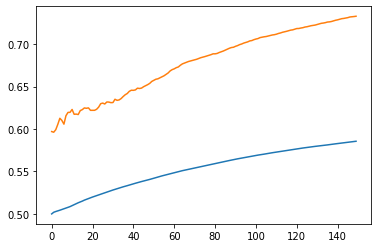

150


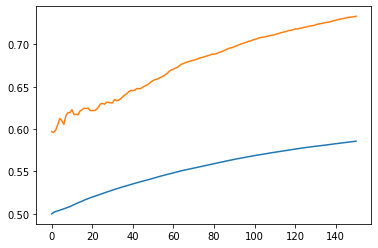

151


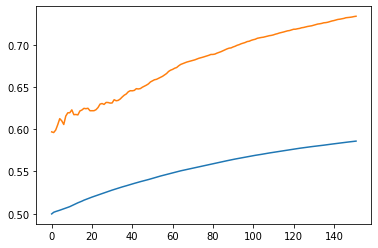

152


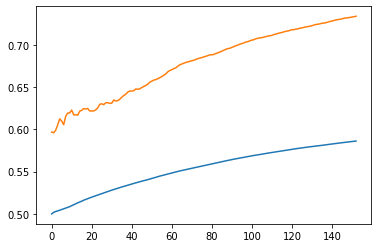

153


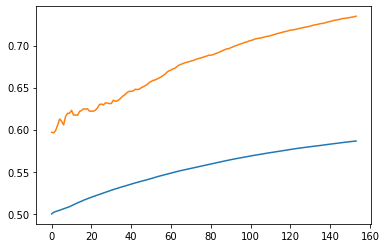

154


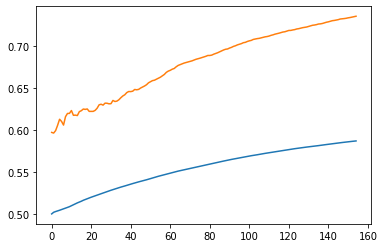

155


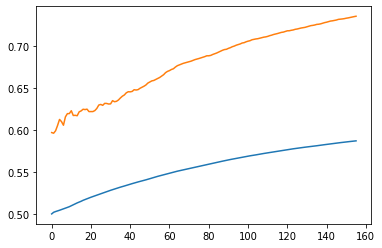

156


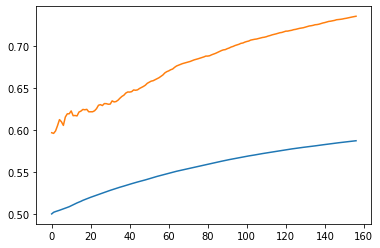

157


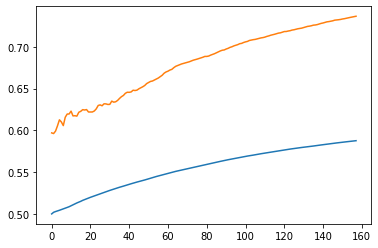

158


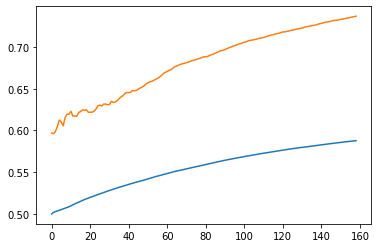

159


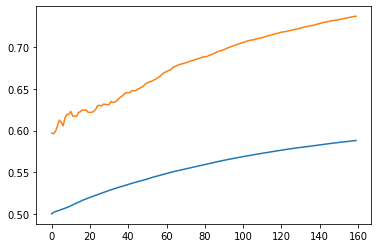

160


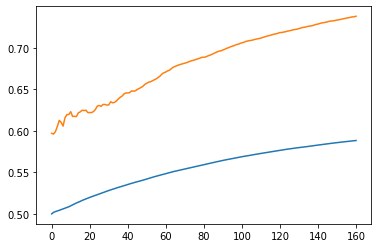

161


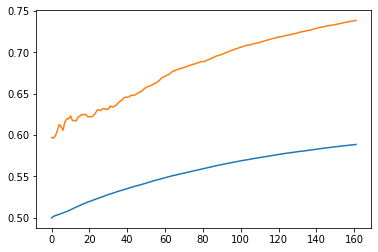

162


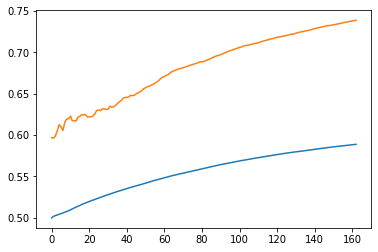

163


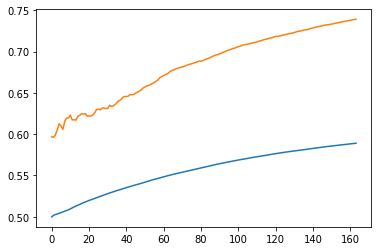

164


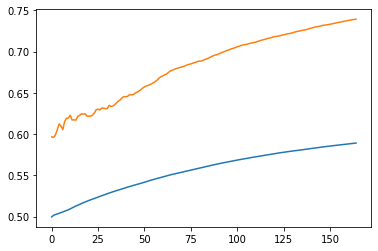

165


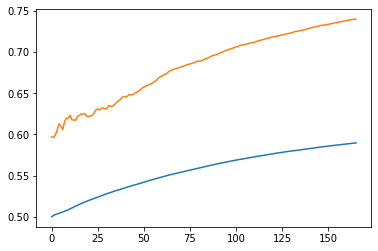

166


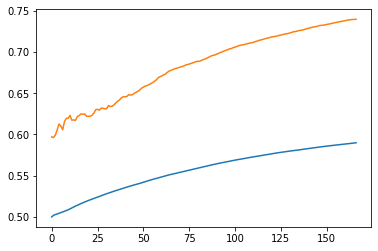

167


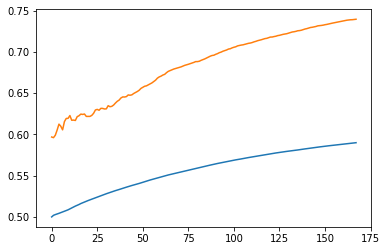

168


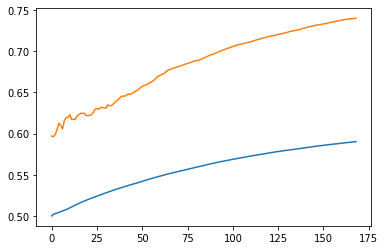

169


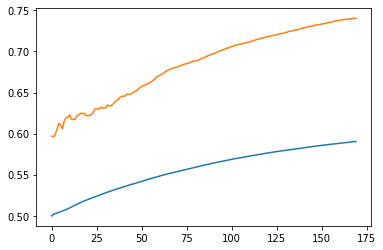

170


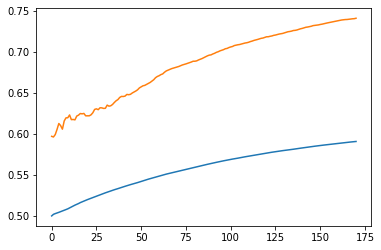

171


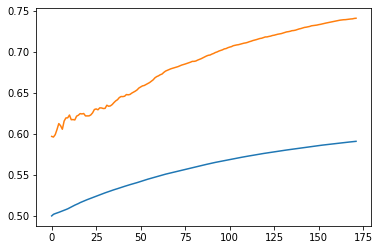

172


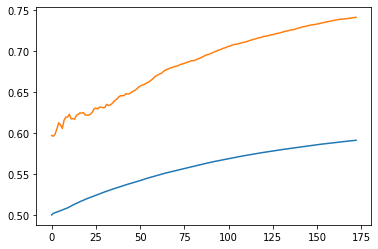

173


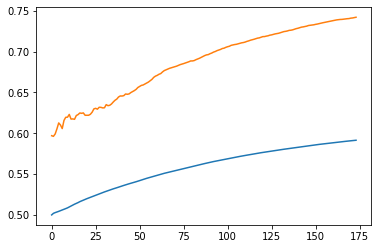

174


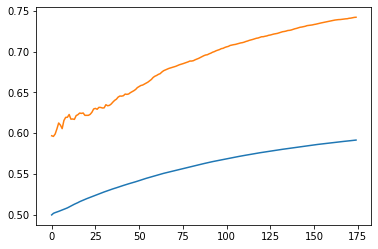

175


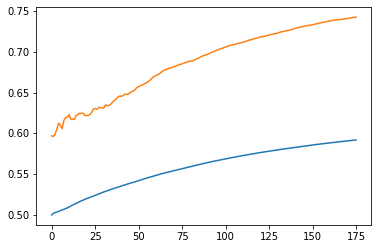

176


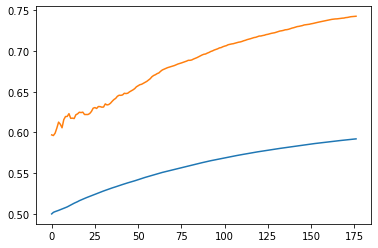

177


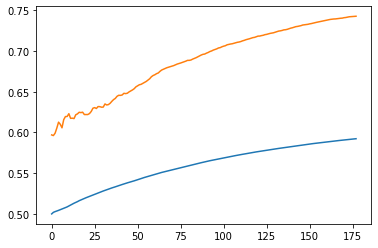

178


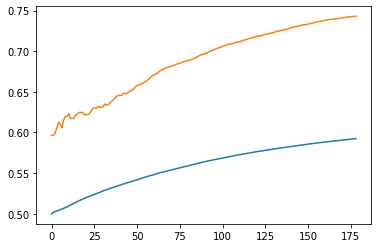

179


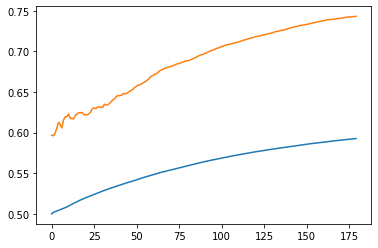

180


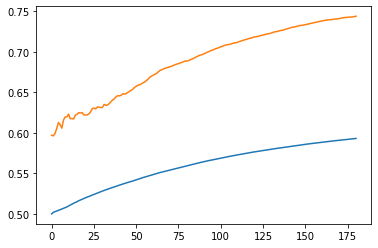

181


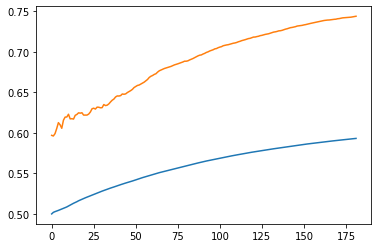

182


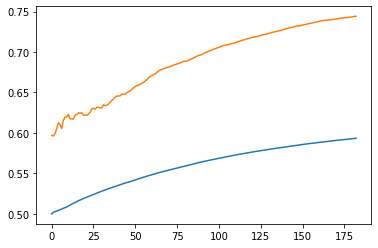

183


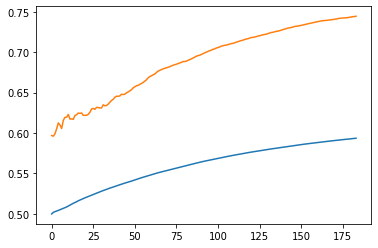

184


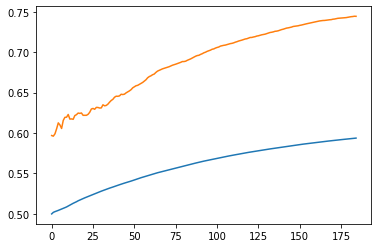

185


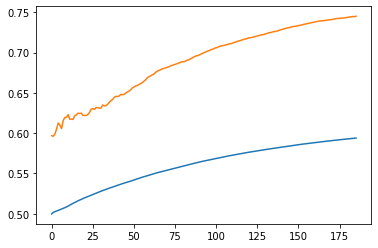

186


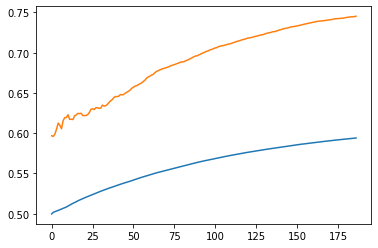

187


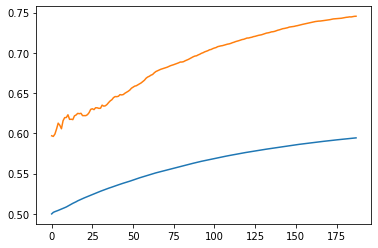

188


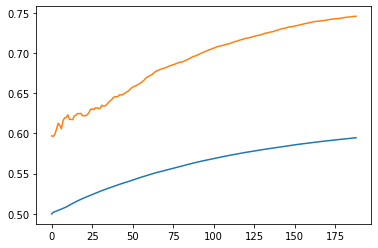

189


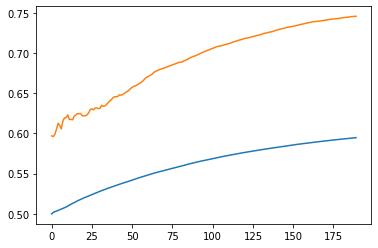

190


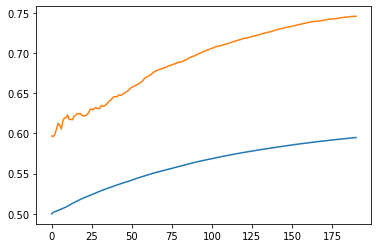

191


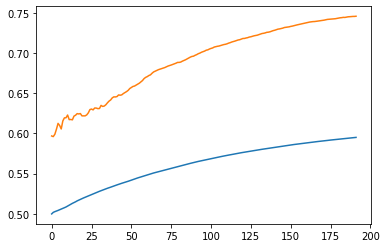

192


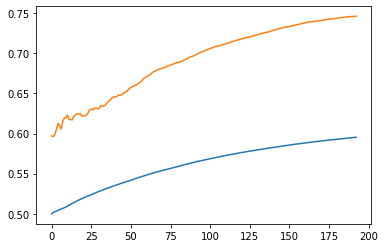

193


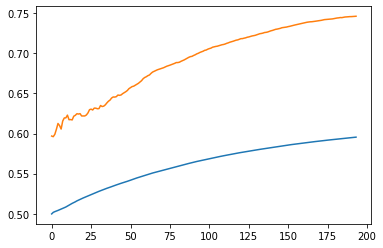

194


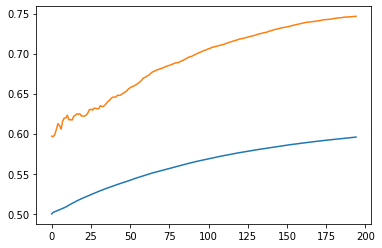

195


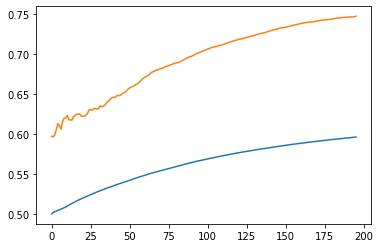

196


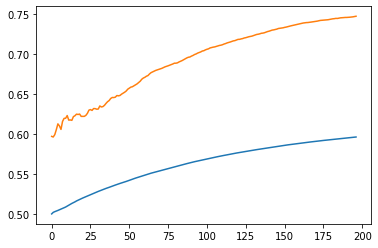

197


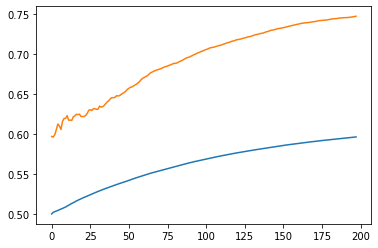

198


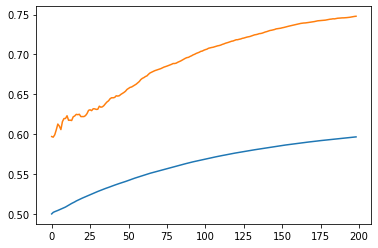

199


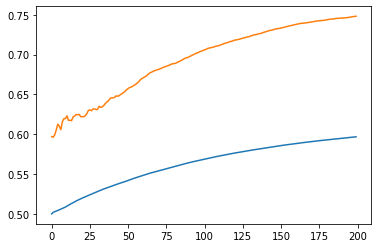

200


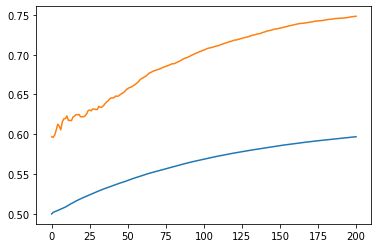

201


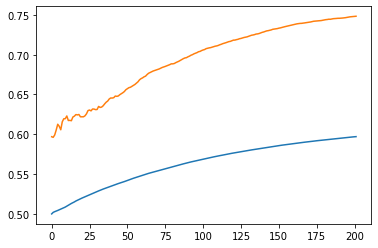

202


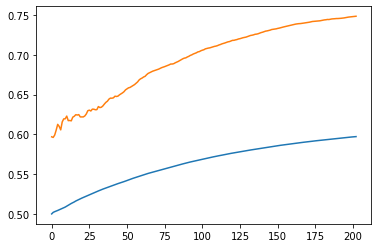

203


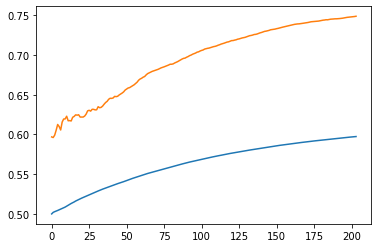

204


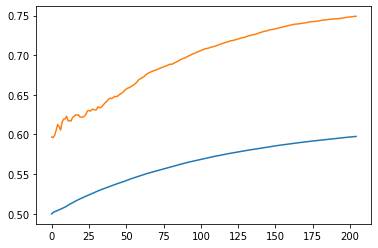

205


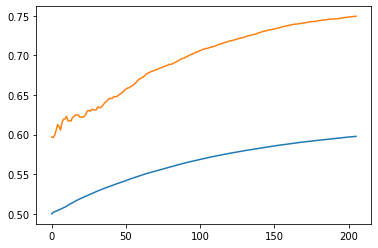

206


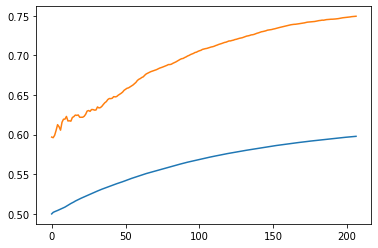

207


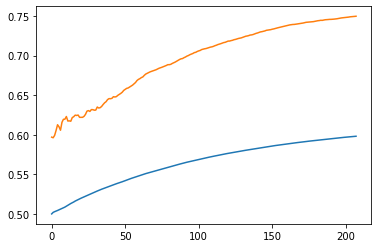

208


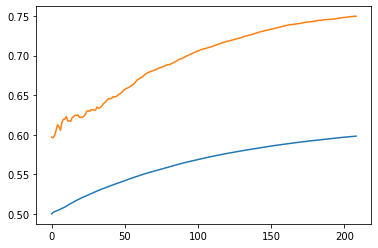

209


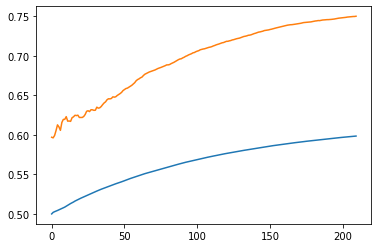

210


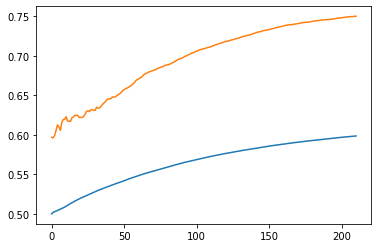

211


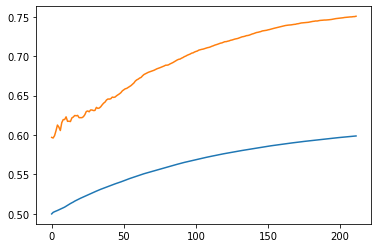

212


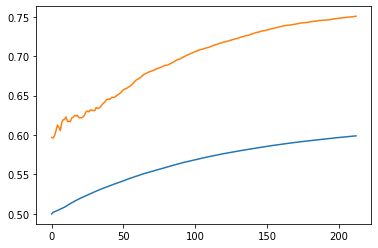

213


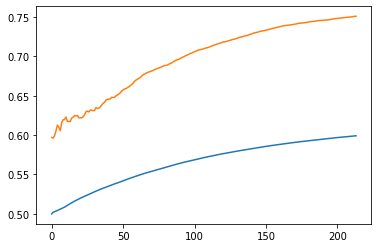

214


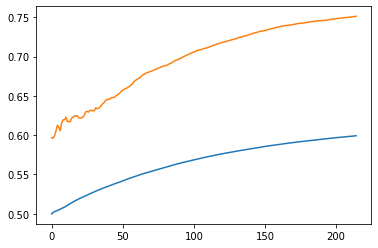

215


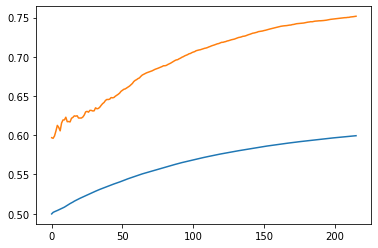

216


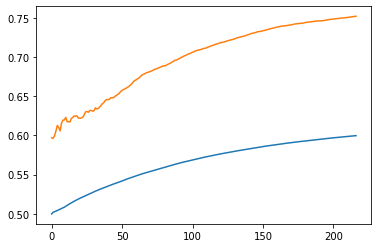

217


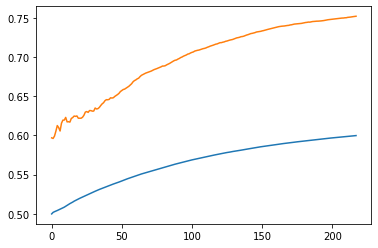

218


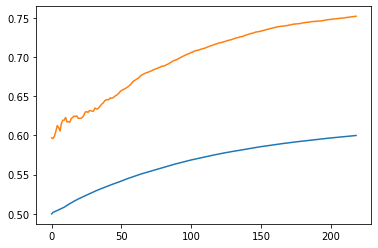

219


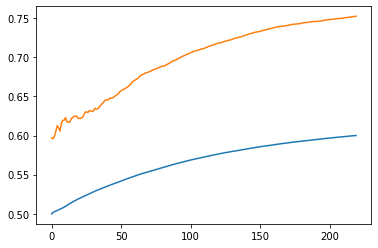

220


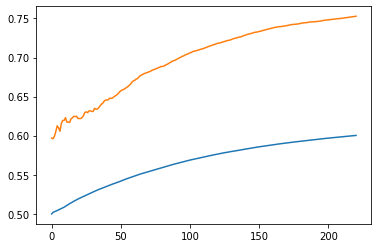

221


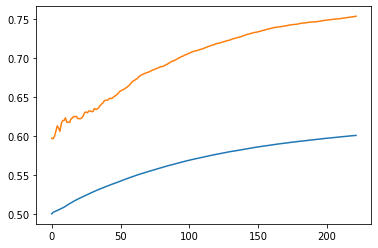

222


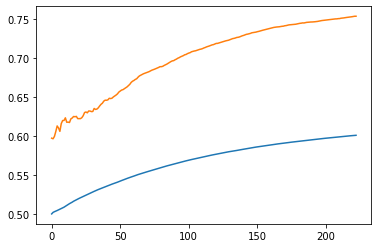

223


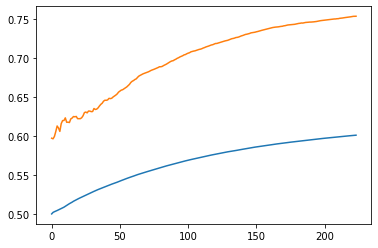

224


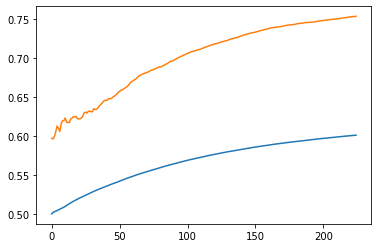

225


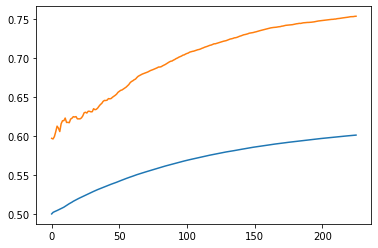

226


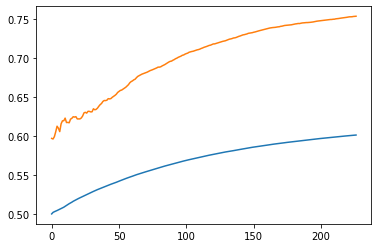

227


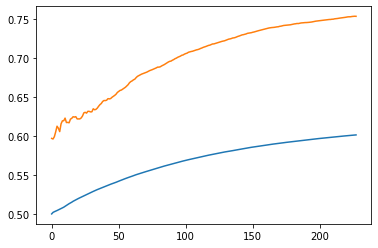

228


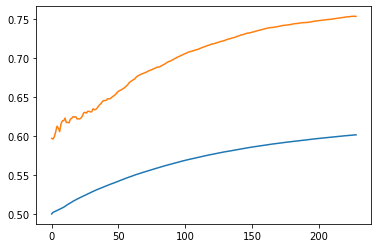

229


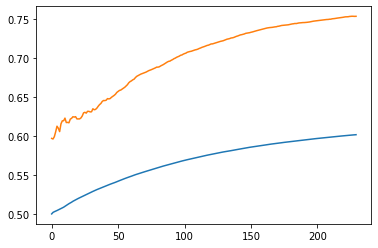

230


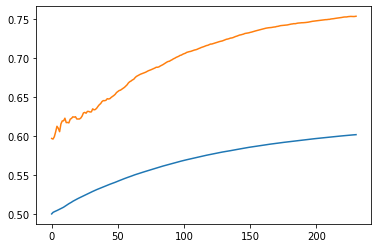

231


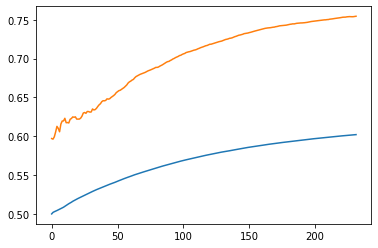

232


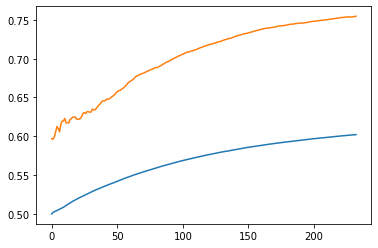

233


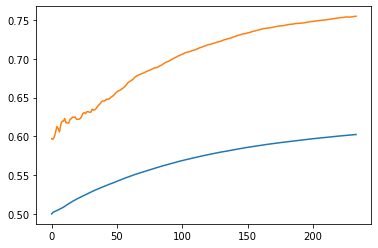

234


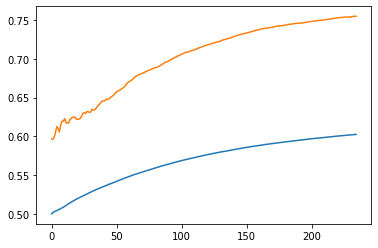

235


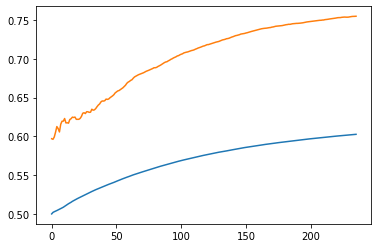

236


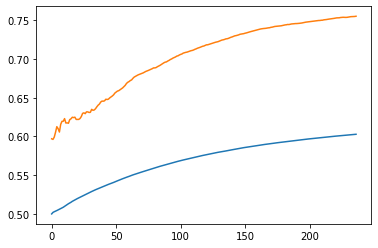

237


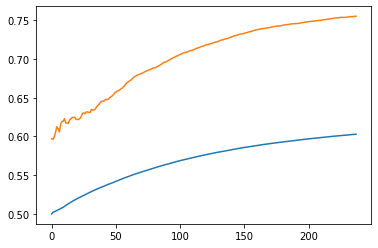

238


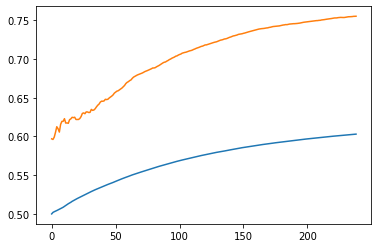

239


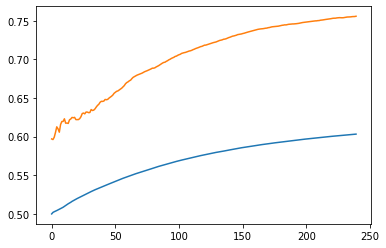

In [ ]:
x = []
y = []
g=[]
z=[]
o=0

nof = 10
n = 200
d=[]
LIF = LIF_Network(n_neurons=n)
dt = LIF.dt

T = 20000
I = np.zeros(shape = [T,n])
# add impulses to the outside actvity
stim = np.zeros([T,nof]) 
ConnStimNetwork = np.zeros([nof,n])
probability = 0.2

for c in range(n):
  for c2 in range(nof):
    Q = np.random.randint(0, high=99)
    if Q/100 < probability:
      ConnStimNetwork[c2,c] = 1

stimorder = np.arange(nof)
np.random.shuffle(stimorder)

freq = 50
num = int((T/freq)/dt)
stim_length = int(T/nof)

for j in range(0,nof):
  for i in range(j*stim_length,(j+1)*stim_length,num): 
    if i<T:
      stim[i][stimorder[j]] = 1 
      I[i] [ConnStimNetwork[j,:]>0] = 1

%matplotlib inline
fig = plt.figure()

for i in range(240):
    W1 = np.copy(LIF.network_W)
    mean_W1 = np.mean(W1[W1 > 0].flatten())

    plotter2(LIF,T*dt, I, pN = 5)

    W2 = np.copy(LIF.network_W)
    mean_W2 = np.mean(W2[W1 > 0].flatten())

    mean_W3 = mean_W2-mean_W1
    d.append(mean_W2)
    order = LIF.kuramato(period = 200, lookBack = 1000)
    g.append(order)

    #print(o,  mean_W3)
    h=sum(d) / len(d)
    gh=sum(g) / len(g)
    x.append(o)
    y.append(h)
    z.append(gh)
    print(o)
    plt.plot(x,y)
    plt.plot(x,z)
    plt.show()
    o=o+1

This below cell runs when the frequency is 25 and the number of nodes is 45. It shows what the different trends in weights are at different times of waiting after the stimulation time.

The result is that the weights go up.:

In [ ]:
o = 25
nof = 45
n = 200
d=[]
c=[]
dt = LIF.dt
T = 10000
I = np.zeros(shape = [T,n])
# add impulses to the outside actvity
stim = np.zeros([T,nof]) 
ConnStimNetwork = np.zeros([nof,n])
probability = 0.2
for c in range(n):
    for c2 in range(nof):
        Q = np.random.randint(0, high=99)
        if Q/100 < probability:
            ConnStimNetwork[c2,c] = 1
stimorder = np.arange(nof)
np.random.shuffle(stimorder)
freq = o
num = int((T/freq)/dt)
stim_length = 50000
for j in range(0,nof):
    for i in range(j*stim_length,(j+1)*stim_length,num): 
        if i<T:
            stim[i][stimorder[j]] = 1 
            I[i] [ConnStimNetwork[j,:]>0] = 1
for T in range(2000,20000,2000):
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    ax = fig.add_subplot()
    for tr in range(1):
        LIF = LIF_Network(n_neurons=n)
        c=[]
        f=[]
        for simcount in range(10):
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            c.append(mean_W2)
            f.append(simcount)
        plt.plot(f,c)
        plt.title("T = " + str(T))
        plt.show()

NameError: ignored

This below cell runs when the frequency is 25 and the number of nodes is 45. It shows what the different trends in weights are at different times of waiting after the stimulation time.

The result is that the weights go down.

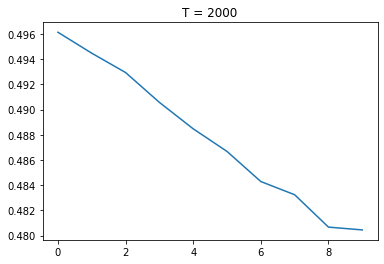

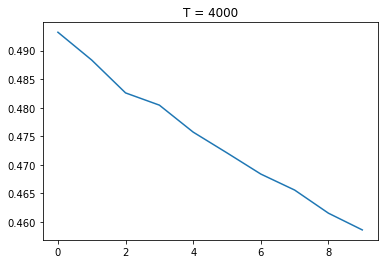

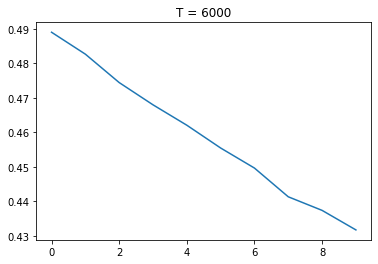

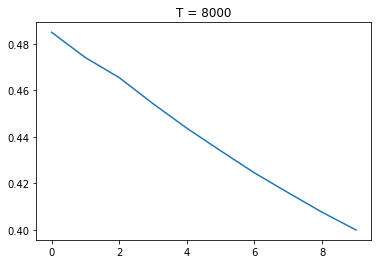

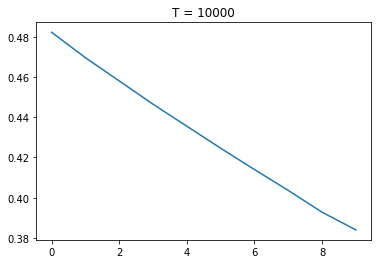

IndexError: ignored

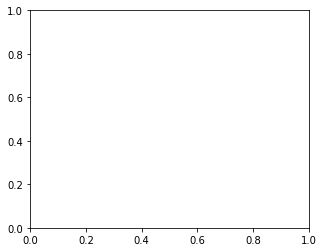

In [ ]:
o = 25
nof = 45
n = 200
d=[]
c=[]
dt = LIF.dt
T = 10000
I = np.zeros(shape = [T,n])
# add impulses to the outside actvity
stim = np.zeros([T,nof]) 
ConnStimNetwork = np.zeros([nof,n])
probability = 0.2
for c in range(n):
    for c2 in range(nof):
        Q = np.random.randint(0, high=99)
        if Q/100 < probability:
            ConnStimNetwork[c2,c] = 1
stimorder = np.arange(nof)
np.random.shuffle(stimorder)
freq = o
num = int((T/freq)/dt)
stim_length = int(T/nof)
for j in range(0,nof):
    for i in range(j*stim_length,(j+1)*stim_length,num): 
        if i<T:
            stim[i][stimorder[j]] = 1 
            I[i] [ConnStimNetwork[j,:]>0] = 1
for T in range(2000,20000,2000):
    fig = plt.figure()
    fig.set_size_inches(5, 4)
    ax = fig.add_subplot()
    for tr in range(1):
        LIF = LIF_Network(n_neurons=n)
        c=[]
        f=[]
        for simcount in range(10):
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            c.append(mean_W2)
            f.append(simcount)
        plt.plot(f,c)
        plt.title("T = " + str(T))
        plt.show()

This below cell is running the stimulation to produce a matrix of weights after the stimulation. The time waiting after the stimulatino is 10 seconds, while the stimulation length itself is 1 second. The number of neurons is 200. 

From this cell, we get a graph showing that the weights of the neurons decreases at frequencies between 10 and 70 Hz, while it increases above 70-80 Hz.

now = 2023-01-02 22:21:44.849722
starting...
trial 0 of 30.0
elapsed time for trial was:  0:00:33.648162
frequency: 1 produced mean weight of: 0.5181294880773564
elapsed time for trial was:  0:00:35.001057
frequency: 1 produced mean weight of: 0.5095670827540867
elapsed time for trial was:  0:00:34.169079
frequency: 1 produced mean weight of: 0.5065977295873078


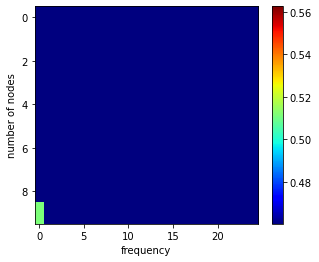

elapsed time for trial was:  0:00:40.819766
frequency: 11 produced mean weight of: 0.49498000371108763
elapsed time for trial was:  0:00:44.198177
frequency: 11 produced mean weight of: 0.48088125303105556
elapsed time for trial was:  0:00:39.909312
frequency: 11 produced mean weight of: 0.49407591823133673


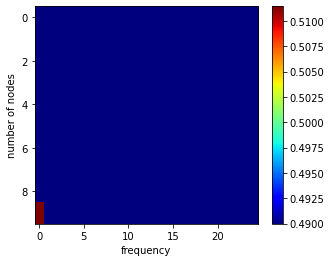

elapsed time for trial was:  0:00:51.942675
frequency: 21 produced mean weight of: 0.49179235619903205
elapsed time for trial was:  0:01:06.933649
frequency: 21 produced mean weight of: 0.4855066288787642
elapsed time for trial was:  0:00:53.619607
frequency: 21 produced mean weight of: 0.4924758446935407


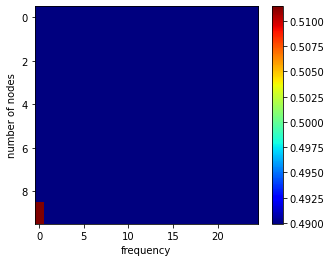

elapsed time for trial was:  0:01:06.020281
frequency: 31 produced mean weight of: 0.4906157498241793
elapsed time for trial was:  0:01:10.139552
frequency: 31 produced mean weight of: 0.48473264424434626
elapsed time for trial was:  0:01:05.424524
frequency: 31 produced mean weight of: 0.49453189269644277


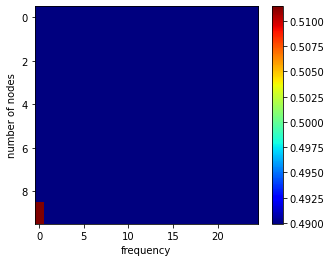

elapsed time for trial was:  0:01:20.342605
frequency: 41 produced mean weight of: 0.48716160614135634
elapsed time for trial was:  0:01:09.303089
frequency: 41 produced mean weight of: 0.4957386890301554
elapsed time for trial was:  0:01:21.009415
frequency: 41 produced mean weight of: 0.4881634499244207


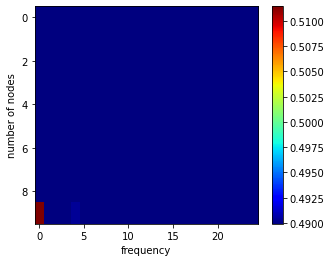

elapsed time for trial was:  0:01:29.902607
frequency: 51 produced mean weight of: 0.4871743643021722
elapsed time for trial was:  0:01:26.167715
frequency: 51 produced mean weight of: 0.4979537389422154
elapsed time for trial was:  0:01:28.814895
frequency: 51 produced mean weight of: 0.4885145586884681


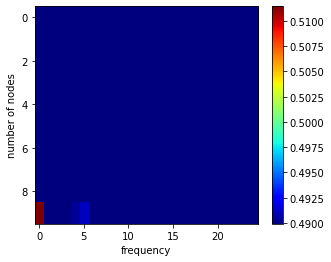

elapsed time for trial was:  0:01:34.663509
frequency: 61 produced mean weight of: 0.4890603336032492
elapsed time for trial was:  0:01:40.660639
frequency: 61 produced mean weight of: 0.4969922384782318
elapsed time for trial was:  0:01:29.946896
frequency: 61 produced mean weight of: 0.49572070698758164


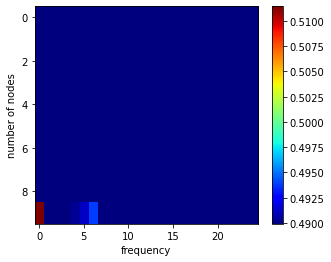

elapsed time for trial was:  0:01:55.794006
frequency: 71 produced mean weight of: 0.4980374430108338
elapsed time for trial was:  0:01:42.079891
frequency: 71 produced mean weight of: 0.48875490717500775
elapsed time for trial was:  0:01:42.605032
frequency: 71 produced mean weight of: 0.48934713673741187


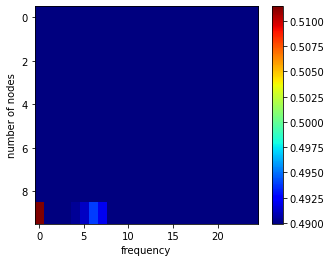

elapsed time for trial was:  0:02:14.795621
frequency: 81 produced mean weight of: 0.5087935543634841
elapsed time for trial was:  0:01:38.461640
frequency: 81 produced mean weight of: 0.49682860402063467
elapsed time for trial was:  0:01:51.048898
frequency: 81 produced mean weight of: 0.49865513400044453


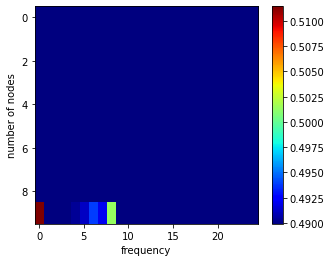

elapsed time for trial was:  0:02:00.584996
frequency: 91 produced mean weight of: 0.5168222674265281
elapsed time for trial was:  0:01:46.736756
frequency: 91 produced mean weight of: 0.5066003386648973
elapsed time for trial was:  0:02:02.164003
frequency: 91 produced mean weight of: 0.5040827891410781


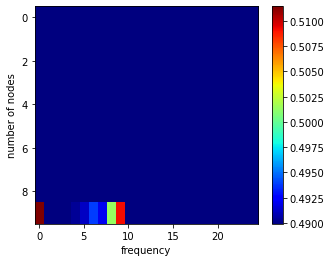

elapsed time for trial was:  0:02:02.487849
frequency: 101 produced mean weight of: 0.5075459083519261
elapsed time for trial was:  0:02:17.739382
frequency: 101 produced mean weight of: 0.5079023893734149
elapsed time for trial was:  0:01:47.134775
frequency: 101 produced mean weight of: 0.506342717339926


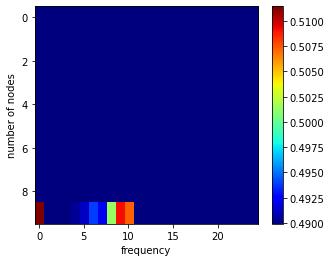

elapsed time for trial was:  0:01:43.737566
frequency: 111 produced mean weight of: 0.5058298190368044
elapsed time for trial was:  0:02:12.471456
frequency: 111 produced mean weight of: 0.5097193557936718
elapsed time for trial was:  0:02:11.797529
frequency: 111 produced mean weight of: 0.5105813154107863


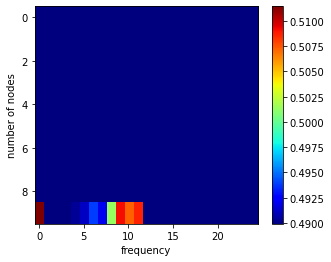

elapsed time for trial was:  0:01:44.710034
frequency: 121 produced mean weight of: 0.49592897173828193
elapsed time for trial was:  0:02:07.548905
frequency: 121 produced mean weight of: 0.5069922630204283
elapsed time for trial was:  0:02:00.176397
frequency: 121 produced mean weight of: 0.511022364943163


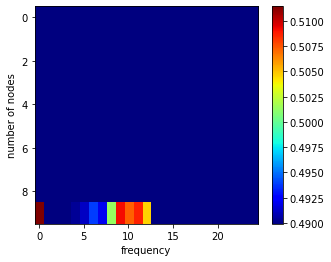

elapsed time for trial was:  0:01:56.473790
frequency: 131 produced mean weight of: 0.4998650208212456
elapsed time for trial was:  0:02:06.502200
frequency: 131 produced mean weight of: 0.4914895218544471
elapsed time for trial was:  0:02:08.465716
frequency: 131 produced mean weight of: 0.5040586789849407


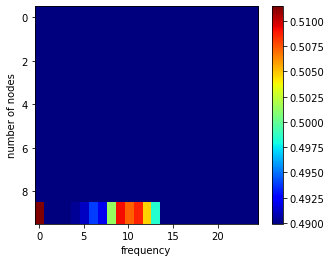

elapsed time for trial was:  0:02:19.024216
frequency: 141 produced mean weight of: 0.49829524797635827
elapsed time for trial was:  0:01:42.675666
frequency: 141 produced mean weight of: 0.5011851672611429
elapsed time for trial was:  0:02:27.147240
frequency: 141 produced mean weight of: 0.5024302589194823


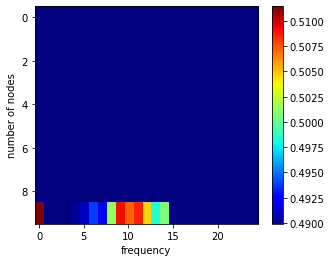

elapsed time for trial was:  0:02:21.188401
frequency: 151 produced mean weight of: 0.4906672262658443
elapsed time for trial was:  0:01:47.175213
frequency: 151 produced mean weight of: 0.5012942689829222
elapsed time for trial was:  0:01:56.306470
frequency: 151 produced mean weight of: 0.5043130984091566


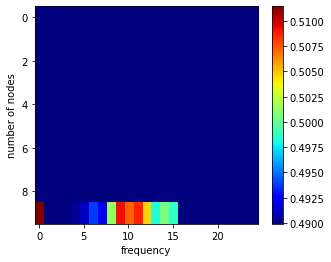

elapsed time for trial was:  0:02:33.434603
frequency: 161 produced mean weight of: 0.49694864827347496
elapsed time for trial was:  0:02:10.021996
frequency: 161 produced mean weight of: 0.4964472080898584
elapsed time for trial was:  0:02:21.566649
frequency: 161 produced mean weight of: 0.5063587347591563


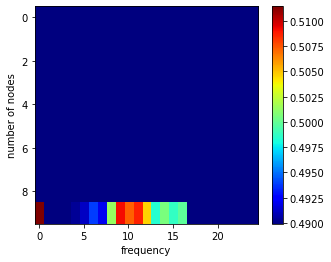

elapsed time for trial was:  0:02:47.294979
frequency: 171 produced mean weight of: 0.5134514494848879
elapsed time for trial was:  0:02:20.617278
frequency: 171 produced mean weight of: 0.5075738460131481
elapsed time for trial was:  0:02:44.917040
frequency: 171 produced mean weight of: 0.49617652754294045


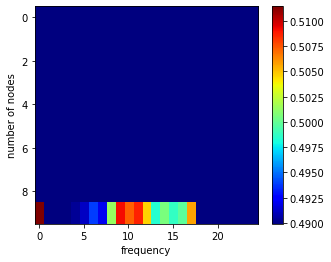

elapsed time for trial was:  0:02:12.284803
frequency: 181 produced mean weight of: 0.5020775891320333
elapsed time for trial was:  0:02:24.422087
frequency: 181 produced mean weight of: 0.5133176052400631
elapsed time for trial was:  0:02:50.090341
frequency: 181 produced mean weight of: 0.518174357038064


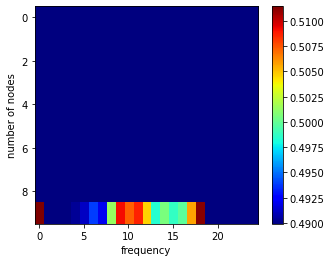

elapsed time for trial was:  0:02:28.970099
frequency: 191 produced mean weight of: 0.5047449777786218
elapsed time for trial was:  0:02:28.797591
frequency: 191 produced mean weight of: 0.5188744045177864
elapsed time for trial was:  0:02:13.446555
frequency: 191 produced mean weight of: 0.5108355529660118


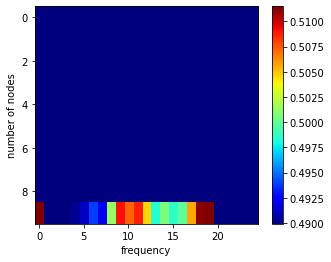

elapsed time for trial was:  0:02:31.523514
frequency: 201 produced mean weight of: 0.5095428340696398
elapsed time for trial was:  0:02:43.239376
frequency: 201 produced mean weight of: 0.5141602139982494
elapsed time for trial was:  0:02:30.087189
frequency: 201 produced mean weight of: 0.5189745290321773


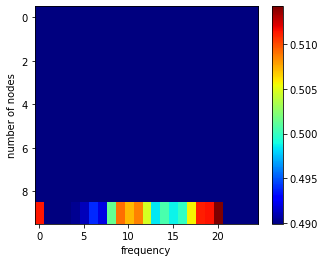

elapsed time for trial was:  0:02:17.174654
frequency: 211 produced mean weight of: 0.5100283718832967
elapsed time for trial was:  0:03:01.569801
frequency: 211 produced mean weight of: 0.5192149226290766
elapsed time for trial was:  0:02:30.258785
frequency: 211 produced mean weight of: 0.50710526456292


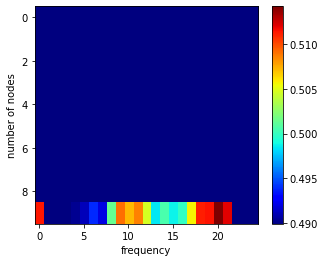

elapsed time for trial was:  0:02:21.961215
frequency: 221 produced mean weight of: 0.5073790985515787
elapsed time for trial was:  0:02:33.019495
frequency: 221 produced mean weight of: 0.5145264520745172
elapsed time for trial was:  0:02:33.316409
frequency: 221 produced mean weight of: 0.5063691834001265


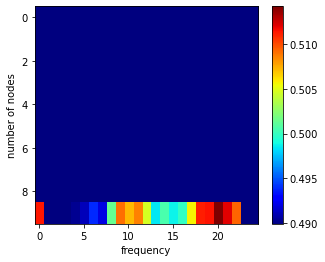

elapsed time for trial was:  0:02:57.208174
frequency: 231 produced mean weight of: 0.5239353401826251
elapsed time for trial was:  0:02:14.978193
frequency: 231 produced mean weight of: 0.49911194165713013
elapsed time for trial was:  0:02:27.371586
frequency: 231 produced mean weight of: 0.5100571195199477


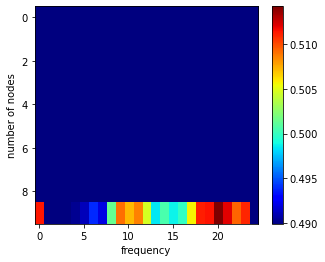

elapsed time for trial was:  0:02:37.195147
frequency: 241 produced mean weight of: 0.4948115206312001
elapsed time for trial was:  0:02:27.356157
frequency: 241 produced mean weight of: 0.5097234172593748
elapsed time for trial was:  0:03:08.107732
frequency: 241 produced mean weight of: 0.5094064383868326


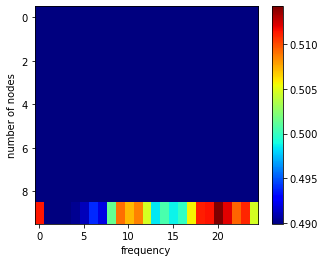

trial 1 of 30.0
elapsed time for trial was:  0:00:34.993937
frequency: 1 produced mean weight of: 0.5157594496735862
elapsed time for trial was:  0:00:33.935922
frequency: 1 produced mean weight of: 0.515221285110509
elapsed time for trial was:  0:00:33.552949
frequency: 1 produced mean weight of: 0.5118191591998763


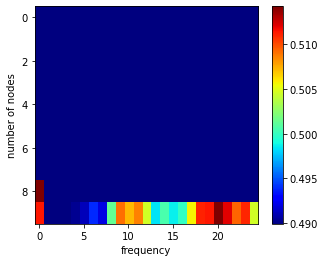

elapsed time for trial was:  0:00:42.832062
frequency: 11 produced mean weight of: 0.47462041831579
elapsed time for trial was:  0:00:41.231156
frequency: 11 produced mean weight of: 0.47452904430741655
elapsed time for trial was:  0:00:42.008587
frequency: 11 produced mean weight of: 0.47500511795378214


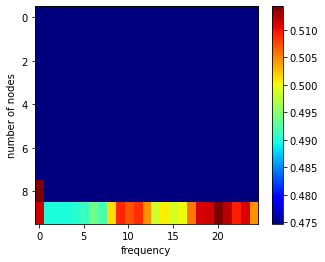

elapsed time for trial was:  0:00:52.135513
frequency: 21 produced mean weight of: 0.45745188567517886
elapsed time for trial was:  0:00:53.930143
frequency: 21 produced mean weight of: 0.44594262644339433
elapsed time for trial was:  0:00:51.834098
frequency: 21 produced mean weight of: 0.454626310448931


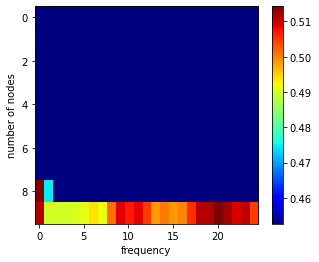

elapsed time for trial was:  0:01:00.720870
frequency: 31 produced mean weight of: 0.4483216102498448
elapsed time for trial was:  0:01:03.312853
frequency: 31 produced mean weight of: 0.433273056687912
elapsed time for trial was:  0:01:03.128317
frequency: 31 produced mean weight of: 0.44667074191677053


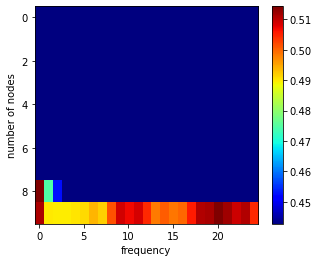

elapsed time for trial was:  0:01:13.169047
frequency: 41 produced mean weight of: 0.4384464971998898
elapsed time for trial was:  0:01:13.582299
frequency: 41 produced mean weight of: 0.4433187122732439
elapsed time for trial was:  0:01:11.590356
frequency: 41 produced mean weight of: 0.44767218253502505


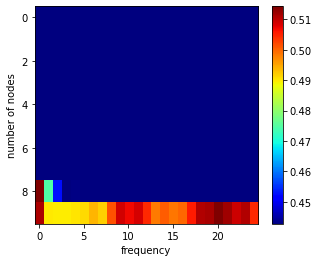

elapsed time for trial was:  0:01:25.075994
frequency: 51 produced mean weight of: 0.42723534303819055
elapsed time for trial was:  0:01:23.281145
frequency: 51 produced mean weight of: 0.43603799918918384
elapsed time for trial was:  0:01:23.386897
frequency: 51 produced mean weight of: 0.4404181431790028


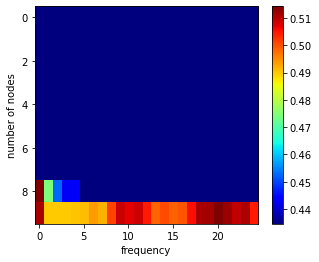

elapsed time for trial was:  0:01:36.940616
frequency: 61 produced mean weight of: 0.4504050269556589
elapsed time for trial was:  0:01:36.341978
frequency: 61 produced mean weight of: 0.4485163561637715
elapsed time for trial was:  0:01:33.449927
frequency: 61 produced mean weight of: 0.4626039320217146


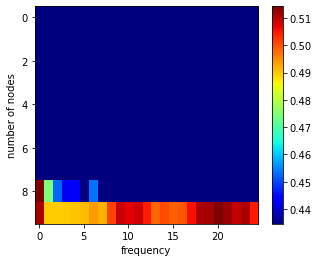

elapsed time for trial was:  0:01:46.868080
frequency: 71 produced mean weight of: 0.4830704852468231
elapsed time for trial was:  0:01:52.479256
frequency: 71 produced mean weight of: 0.48956314092638153
elapsed time for trial was:  0:01:48.747385
frequency: 71 produced mean weight of: 0.47737317381175454


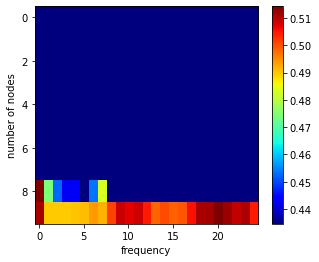

elapsed time for trial was:  0:01:58.781215
frequency: 81 produced mean weight of: 0.525363386709989
elapsed time for trial was:  0:01:55.392458
frequency: 81 produced mean weight of: 0.5199258968592401
elapsed time for trial was:  0:01:48.333577
frequency: 81 produced mean weight of: 0.511183099830045


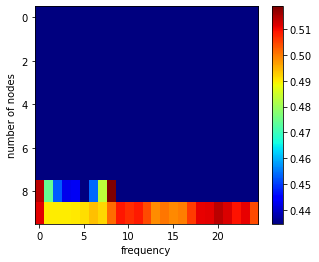

elapsed time for trial was:  0:02:06.713821
frequency: 91 produced mean weight of: 0.5387969679162723
elapsed time for trial was:  0:01:46.820894
frequency: 91 produced mean weight of: 0.5173294792363617
elapsed time for trial was:  0:02:00.533773
frequency: 91 produced mean weight of: 0.5367786452354624


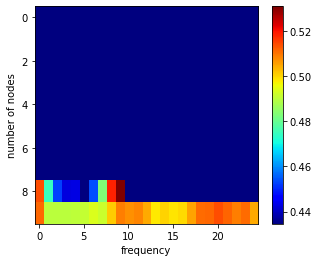

elapsed time for trial was:  0:02:09.054553
frequency: 101 produced mean weight of: 0.5324471925491177
elapsed time for trial was:  0:02:00.266664
frequency: 101 produced mean weight of: 0.5208365087819147
elapsed time for trial was:  0:01:55.308607
frequency: 101 produced mean weight of: 0.5208117916960577


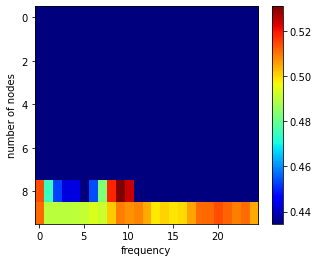

elapsed time for trial was:  0:02:06.402690
frequency: 111 produced mean weight of: 0.5238474075549487
elapsed time for trial was:  0:02:06.903368
frequency: 111 produced mean weight of: 0.5171978429834638
elapsed time for trial was:  0:02:10.782036
frequency: 111 produced mean weight of: 0.5260902563864813


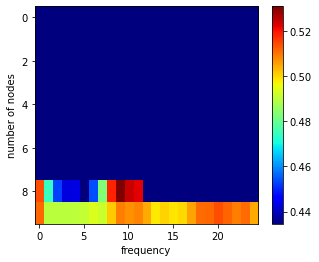

elapsed time for trial was:  0:02:05.004117
frequency: 121 produced mean weight of: 0.510196209188159
elapsed time for trial was:  0:01:53.416636
frequency: 121 produced mean weight of: 0.4990216185282073
elapsed time for trial was:  0:02:06.955492
frequency: 121 produced mean weight of: 0.5108580779499504


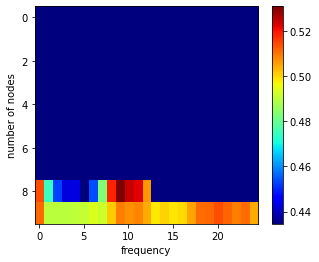

elapsed time for trial was:  0:02:09.478786
frequency: 131 produced mean weight of: 0.510807478127801
elapsed time for trial was:  0:02:11.125435
frequency: 131 produced mean weight of: 0.5018517091652536
elapsed time for trial was:  0:02:14.562089
frequency: 131 produced mean weight of: 0.4989925543515275


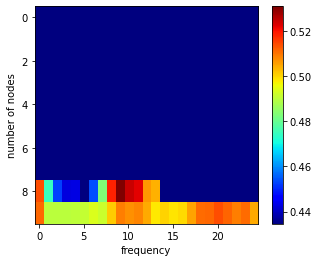

elapsed time for trial was:  0:02:23.287382
frequency: 141 produced mean weight of: 0.5020393633243923
elapsed time for trial was:  0:02:19.222222
frequency: 141 produced mean weight of: 0.5094963245650557
elapsed time for trial was:  0:02:18.039088
frequency: 141 produced mean weight of: 0.5056901455423097


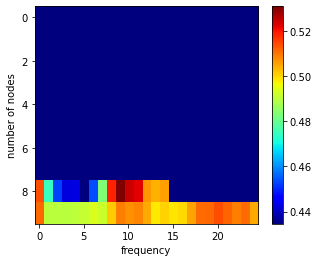

elapsed time for trial was:  0:02:12.442126
frequency: 151 produced mean weight of: 0.4941375106794877
elapsed time for trial was:  0:02:24.747173
frequency: 151 produced mean weight of: 0.5028263670601374
elapsed time for trial was:  0:02:15.137298
frequency: 151 produced mean weight of: 0.5023684431867191


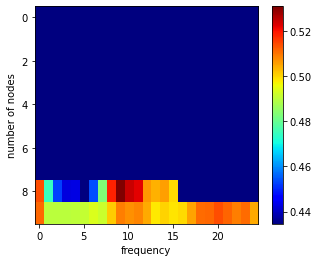

elapsed time for trial was:  0:02:29.766433
frequency: 161 produced mean weight of: 0.4969026790036891
elapsed time for trial was:  0:02:28.885158
frequency: 161 produced mean weight of: 0.4942780398515915
elapsed time for trial was:  0:02:20.020062
frequency: 161 produced mean weight of: 0.4894460186644598


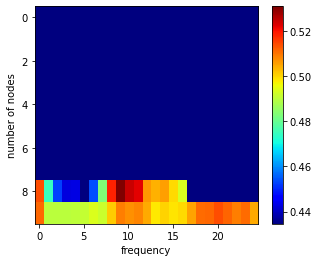

elapsed time for trial was:  0:02:29.703992
frequency: 171 produced mean weight of: 0.49149061496721347
elapsed time for trial was:  0:02:25.518456
frequency: 171 produced mean weight of: 0.48490265289781687
elapsed time for trial was:  0:02:26.219515
frequency: 171 produced mean weight of: 0.48947171573971776


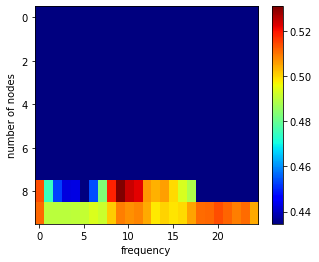

elapsed time for trial was:  0:02:17.419693
frequency: 181 produced mean weight of: 0.48362914702090215
elapsed time for trial was:  0:02:37.344699
frequency: 181 produced mean weight of: 0.4929815394444493
elapsed time for trial was:  0:02:40.613805
frequency: 181 produced mean weight of: 0.4885359805820102


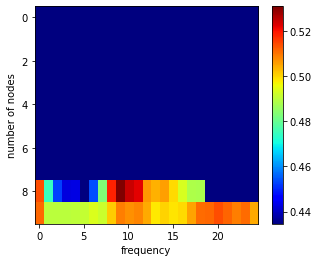

elapsed time for trial was:  0:02:39.402195
frequency: 191 produced mean weight of: 0.47802121887954385
elapsed time for trial was:  0:02:40.620028
frequency: 191 produced mean weight of: 0.48843285082797927
elapsed time for trial was:  0:02:36.043548
frequency: 191 produced mean weight of: 0.4924738171101635


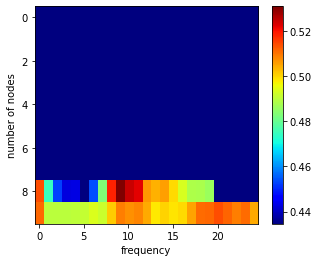

elapsed time for trial was:  0:02:27.215971
frequency: 201 produced mean weight of: 0.49081182989625244
elapsed time for trial was:  0:02:41.556010
frequency: 201 produced mean weight of: 0.49254433824581706
elapsed time for trial was:  0:02:57.222769
frequency: 201 produced mean weight of: 0.5035146078500174


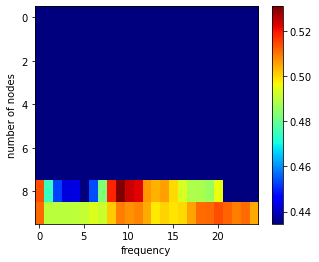

elapsed time for trial was:  0:02:52.701487
frequency: 211 produced mean weight of: 0.4891969527755829
elapsed time for trial was:  0:02:33.713261
frequency: 211 produced mean weight of: 0.48395342281794224
elapsed time for trial was:  0:02:38.257251
frequency: 211 produced mean weight of: 0.4934389914320928


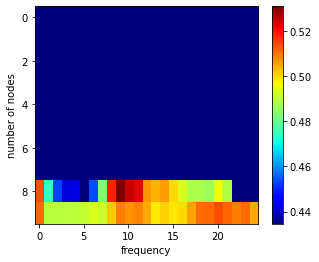

elapsed time for trial was:  0:02:44.344873
frequency: 221 produced mean weight of: 0.5019207141294437
elapsed time for trial was:  0:02:37.958389
frequency: 221 produced mean weight of: 0.4855016402667207
elapsed time for trial was:  0:02:44.927081
frequency: 221 produced mean weight of: 0.4972459893076206


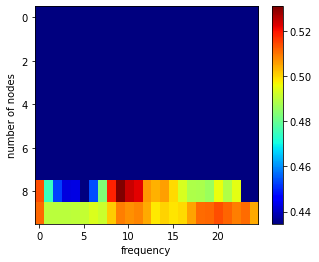

elapsed time for trial was:  0:02:39.342794
frequency: 231 produced mean weight of: 0.48607491310854295
elapsed time for trial was:  0:02:37.325072
frequency: 231 produced mean weight of: 0.48498645274894947
elapsed time for trial was:  0:02:53.561336
frequency: 231 produced mean weight of: 0.5096898946275521


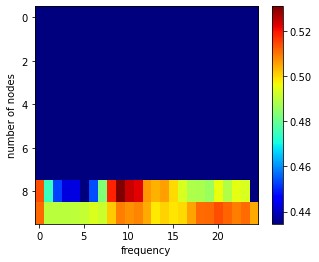

elapsed time for trial was:  0:02:29.805432
frequency: 241 produced mean weight of: 0.4880973496710206
elapsed time for trial was:  0:02:38.444275
frequency: 241 produced mean weight of: 0.4912425070985094
elapsed time for trial was:  0:02:58.247630
frequency: 241 produced mean weight of: 0.5014571263333155


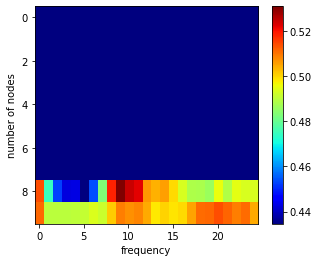

trial 2 of 30.0
elapsed time for trial was:  0:00:35.662533
frequency: 1 produced mean weight of: 0.520104924809764
elapsed time for trial was:  0:00:35.351708
frequency: 1 produced mean weight of: 0.516261276854765
elapsed time for trial was:  0:00:34.310022
frequency: 1 produced mean weight of: 0.5121882429504205


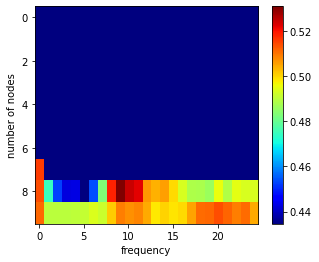

elapsed time for trial was:  0:00:42.899566
frequency: 11 produced mean weight of: 0.4734729228760011
elapsed time for trial was:  0:00:41.928407
frequency: 11 produced mean weight of: 0.47206654998250613
elapsed time for trial was:  0:00:42.043507
frequency: 11 produced mean weight of: 0.477106755032193


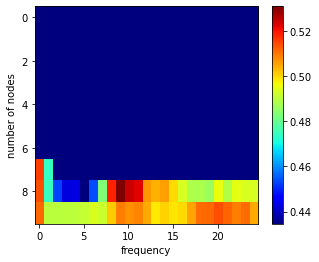

elapsed time for trial was:  0:00:53.139018
frequency: 21 produced mean weight of: 0.45558847684428366
elapsed time for trial was:  0:00:52.283341
frequency: 21 produced mean weight of: 0.4491540377941816
elapsed time for trial was:  0:00:51.676893
frequency: 21 produced mean weight of: 0.452421256123029


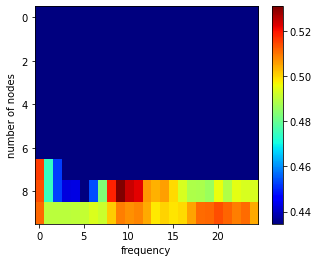

elapsed time for trial was:  0:01:04.637151
frequency: 31 produced mean weight of: 0.4238286198373904
elapsed time for trial was:  0:01:04.856715
frequency: 31 produced mean weight of: 0.4270542863010723
elapsed time for trial was:  0:01:04.352763
frequency: 31 produced mean weight of: 0.43267022358320867


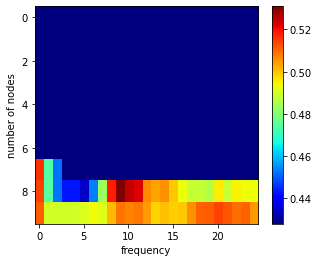

elapsed time for trial was:  0:01:11.599510
frequency: 41 produced mean weight of: 0.42081081418701477
elapsed time for trial was:  0:01:11.182639
frequency: 41 produced mean weight of: 0.4389731030922942
elapsed time for trial was:  0:01:14.074412
frequency: 41 produced mean weight of: 0.41886583556275947


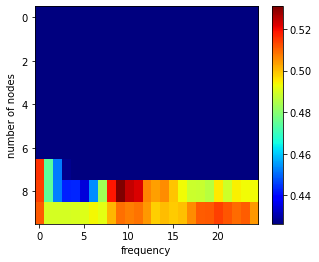

elapsed time for trial was:  0:01:20.612745
frequency: 51 produced mean weight of: 0.4270023486346034
elapsed time for trial was:  0:01:26.749810
frequency: 51 produced mean weight of: 0.42365263527280583
elapsed time for trial was:  0:01:24.209517
frequency: 51 produced mean weight of: 0.41775272367345684


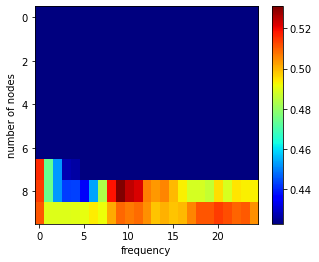

elapsed time for trial was:  0:01:40.948587
frequency: 61 produced mean weight of: 0.42516189599366133
elapsed time for trial was:  0:01:34.223820
frequency: 61 produced mean weight of: 0.43722978470213336
elapsed time for trial was:  0:01:35.837819
frequency: 61 produced mean weight of: 0.43164764158631364


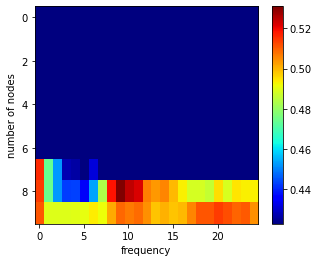

elapsed time for trial was:  0:01:46.407273
frequency: 71 produced mean weight of: 0.4699240908266422
elapsed time for trial was:  0:01:45.257507
frequency: 71 produced mean weight of: 0.4774292828409821
elapsed time for trial was:  0:01:48.969971
frequency: 71 produced mean weight of: 0.47448391309838656


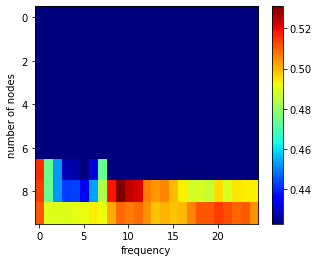

elapsed time for trial was:  0:01:55.651400
frequency: 81 produced mean weight of: 0.5159552991296326
elapsed time for trial was:  0:01:57.119341
frequency: 81 produced mean weight of: 0.521367147640053
elapsed time for trial was:  0:01:54.123795
frequency: 81 produced mean weight of: 0.5232218109622714


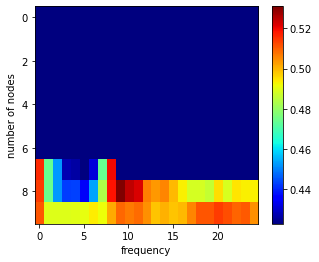

elapsed time for trial was:  0:02:02.582870
frequency: 91 produced mean weight of: 0.5382831053285811
elapsed time for trial was:  0:01:54.689872
frequency: 91 produced mean weight of: 0.5293949174715958
elapsed time for trial was:  0:01:56.476092
frequency: 91 produced mean weight of: 0.52978497984938


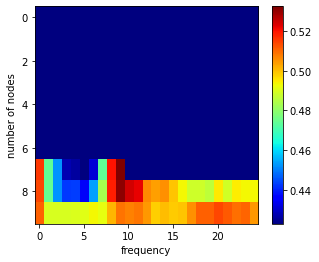

elapsed time for trial was:  0:01:59.934247
frequency: 101 produced mean weight of: 0.5222779418544737
elapsed time for trial was:  0:01:57.763594
frequency: 101 produced mean weight of: 0.5262560947541627
elapsed time for trial was:  0:02:02.059894
frequency: 101 produced mean weight of: 0.5264149981811068


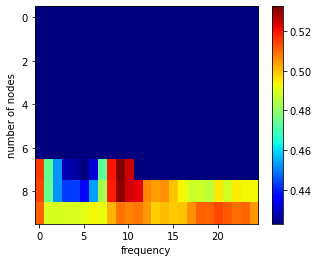

elapsed time for trial was:  0:02:08.555843
frequency: 111 produced mean weight of: 0.5246021418891712
elapsed time for trial was:  0:02:01.427641
frequency: 111 produced mean weight of: 0.51681707677533
elapsed time for trial was:  0:02:09.905354
frequency: 111 produced mean weight of: 0.525374369318431


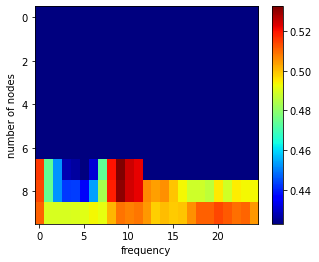

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=2)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([10,25])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 100000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,5):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 251, 10):
        jj = jj+1
        meanW=[]
        for i in range(3):
            LIF = LIF_Network(n_neurons=n)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(mean_W2))
        results_matrix[ii][jj]=np.mean(meanW)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
    
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

This below cell is running the stimulation to produce a matrix of the order of the neuron system after the stimulation. The time waiting after the stimulatino is 15 seconds, while the stimulation length itself is 1 second. The number of neurons is 200. 

From this cell, we get a graph showing that the order of the neurons approximately decreases at frequencies between 10 and 70 Hz, while it increases above 70-80 Hz, similar to the weights. However, it is slightly more random than the weights.

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=2)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([17,20])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 150000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,3):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 201, 10):
        jj = jj+1
        meanW=[]
        for i in range(5):
            LIF = LIF_Network(n_neurons=n)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            
            plotter2(LIF,T*dt, I, pN = 5)
            order = LIF.kuramato(period = 200, lookBack = 1000)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(order))
        results_matrix[ii][jj]=np.mean(order)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

## Effects of stimulation frequency and number of stimulation sites on weights and synchrony.


These next two cells produce matrixes with the frequency vs. number of nodes, with a colorbar representing the weights of the neurons in the first cell and the synchrony of the neurons in the second cell. They use the new version of the connectivity model, which makes the connectivity dependent on the distance between neurons.

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=200)
LIF.structured_conn(LIF)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([10,25])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 100000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,5):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 251, 10):
        jj = jj+1
        meanW=[]
        for i in range(3):
            LIF = LIF_Network(n_neurons=n)
            LIF.structured_conn(LIF)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            plotter2(LIF,T*dt, I, pN = 5)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(mean_W2))
        results_matrix[ii][jj]=np.mean(meanW)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
    
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

In [ ]:
from datetime import datetime
LIF = LIF_Network(n_neurons=200)
LIF.structured_conn(LIF)
# datetime object containing current date and time
now = datetime.now()
print("now =", now) 
results_matrix = np.zeros([17,20])
ii = -1
jj = -1
hj=0
# Experiment parameters
T = 150000
stim_length = 10000
n = 200
dt = LIF.dt
probability = 0.2
print("starting...")
for k in range(1,51,3):
    ii = ii+1
    jj=-1
    nof = k
    print("trial " + str(ii) + " of " + str(60/2))
    for o in range(1, 201, 10):
        jj = jj+1
        meanW=[]
        for i in range(5):
            LIF = LIF_Network(n_neurons=n)
            LIF.structured_conn(LIF)
            I = np.zeros(shape = [T,n])
            # add impulses to the outside actvity
            stim = np.zeros([T,nof]) 
            ConnStimNetwork = np.zeros([nof,n])
            for c in range(n):
                for c2 in range(nof):
                    Q = np.random.randint(0, high=99)
                    if Q/100 < probability:
                        ConnStimNetwork[c2,c] = 1
            stimorder = np.arange(nof)
            np.random.shuffle(stimorder)
            freq = o
            num = int(1000/freq/dt)
            held_i = 0    
            while held_i<T:
                for j in range(nof):
                    for i in range(0,stim_length,num): 
                        if i+held_i<T:
                            stim[i+held_i][stimorder[j]] = 1 
                            I[i+held_i] [ConnStimNetwork[j,:]>0] = 1              
                    held_i = held_i + stim_length
            W1 = np.copy(LIF.network_W)
            mean_W1 = np.mean(W1[W1 > 0].flatten())
            
            plotter2(LIF,T*dt, I, pN = 5)
            order = LIF.kuramato(period = 200, lookBack = 1000)
            W2 = np.copy(LIF.network_W)
            mean_W2 = np.mean(W2[W1 > 0].flatten())
            meanW.append(mean_W2)
            print("elapsed time for trial was: ", datetime.now()-now)
            now = datetime.now()
            print("frequency: " + str(o) +" produced mean weight of: " + str(order))
        results_matrix[ii][jj]=np.mean(order)
        %matplotlib inline
        fig = plt.figure()
        fig.set_size_inches(5, 4)
        ax = fig.add_subplot()
        plt.imshow(np.flipud(results_matrix),aspect='equal',interpolation='none', vmin=np.min(results_matrix[np.nonzero(results_matrix)]), vmax=np.max(results_matrix[np.nonzero(results_matrix)]), cmap='jet')
        plt.colorbar()
        ax.set_aspect('auto')
        plt.ylabel('number of nodes')
        plt.xlabel('frequency')
        plt.show()

# Citations
<a name="citations">
</a>



Kromer JA, Khaledi-Nasab A, Tass PA. Impact of number of stimulation sites on long-lasting desynchronization effects of coordinated reset stimulation. Chaos. 2020 Aug;30(8):083134. doi: 10.1063/5.0015196. PMID: 32872805.
